In [1]:
from functools import partial

from transformers import CLIPVisionModel 
import torch
from torch import nn
from torchvision import transforms

from PIL import Image
import os
proxy = ""
os.environ['http_proxy'] = proxy
os.environ['https_proxy'] = proxy
# import subprocess
# import os

# result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
# output = result.stdout
# for line in output.splitlines():
#     if '=' in line:
#         var, value = line.split('=', 1)
#         os.environ[var] = value
import torch
import torch.nn as nn
from transformers import CLIPVisionModel
from torchvision import transforms
import sys
sys.path.append("../")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/thagafhh/work/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/thagafhh/work/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
import transformers
print(transformers.__version__)
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

4.34.0


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import clip
from torch.nn import functional as F
import torch.nn as nn
from torchvision import transforms
from PIL import Image
train = False
classes = None
pictures= None

def load_data():
    data_list = []
    label_list = []
    texts = []
    images = []
    
    if train:
        text_directory = "/ibex/user/thagafhh/data/training_images"
    else:
        text_directory = "/ibex/user/thagafhh/data/test_images"
    dirnames = [d for d in os.listdir(text_directory) if os.path.isdir(os.path.join(text_directory, d))]
    dirnames.sort()
    
    if classes is not None:
        dirnames = [dirnames[i] for i in classes]

    for dir in dirnames:

        try:
            idx = dir.index('_')
            description = dir[idx+1:]
        except ValueError:
            print(f"Skipped: {dir} due to no '_' found.")
            continue
            
        new_description = f"{description}"
        texts.append(new_description)

    if train:
        img_directory = "/ibex/user/thagafhh/data/training_images"
    else:
        img_directory ="/ibex/user/thagafhh/data/test_images"
    
    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
    all_folders.sort()

    if classes is not None and pictures is not None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            pic_idx = pictures[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                if pic_idx < len(all_images):
                    images.append(os.path.join(folder_path, all_images[pic_idx]))
    elif classes is not None and pictures is None:
        images = []
        for i in range(len(classes)):
            class_idx = classes[i]
            if class_idx < len(all_folders):
                folder = all_folders[class_idx]
                folder_path = os.path.join(img_directory, folder)
                all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_images.sort()
                images.extend(os.path.join(folder_path, img) for img in all_images)
    elif classes is None:
        images = []
        for folder in all_folders:
            folder_path = os.path.join(img_directory, folder)
            all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.sort()  
            images.extend(os.path.join(folder_path, img) for img in all_images)
    else:

        print("Error")
    return texts, images
texts, images = load_data()

texts
# images

['aircraft_carrier',
 'antelope',
 'backscratcher',
 'balance_beam',
 'banana',
 'baseball_bat',
 'basil',
 'basketball',
 'bassoon',
 'baton4',
 'batter',
 'beaver',
 'bench',
 'bike',
 'birthday_cake',
 'blowtorch',
 'boat',
 'bok_choy',
 'bonnet',
 'bottle_opener',
 'brace',
 'bread',
 'breadbox',
 'bug',
 'buggy',
 'bullet',
 'bun',
 'bush',
 'calamari',
 'candlestick',
 'cart',
 'cashew',
 'cat',
 'caterpillar',
 'cd_player',
 'chain',
 'chaps',
 'cheese',
 'cheetah',
 'chest2',
 'chime',
 'chopsticks',
 'cleat',
 'cleaver',
 'coat',
 'cobra',
 'coconut',
 'coffee_bean',
 'coffeemaker',
 'cookie',
 'cordon_bleu',
 'coverall',
 'crab',
 'creme_brulee',
 'crepe',
 'crib',
 'croissant',
 'crow',
 'cruise_ship',
 'crumb',
 'cupcake',
 'dagger',
 'dalmatian',
 'dessert',
 'dragonfly',
 'dreidel',
 'drum',
 'duffel_bag',
 'eagle',
 'eel',
 'egg',
 'elephant',
 'espresso',
 'face_mask',
 'ferry',
 'flamingo',
 'folder',
 'fork',
 'freezer',
 'french_horn',
 'fruit',
 'garlic',
 'glove',


In [4]:
class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.clip = CLIPVisionModel.from_pretrained('openai/clip-vit-large-patch14').to(torch.bfloat16)
        # self.clip_size = (224, 224)

        self.preprocess = CLIPImageProcessor(
            size={"height": 512, "width": 512},
            crop_size={"height": 512, "width": 512},
        )


        # for param in self.clip.parameters():
        #     param.requires_grad = False
        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        "h94/IP-Adapter", 
        # "laion2b_s32b_b79k",
        subfolder="models/image_encoder",
        torch_dtype=torch.float16,
        ).to("cuda")
        
        
    
def encode_image(image, image_encoder, feature_extractor, num_images_per_prompt=1, device='cuda'):
    dtype = next(image_encoder.parameters()).dtype

    if not isinstance(image, torch.Tensor):
        image = feature_extractor(image, return_tensors="pt").pixel_values # [1, 3, 224, 224]
        print("image", image.shape)
    image = image.to(device=device, dtype=dtype)
    image_embeds = image_encoder(image).image_embeds # (1, 1024)
    image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0) # (num_images_per_prompt, 1024)

    return image_embeds

clip_encoder = CLIPEncoder().to(device)


In [5]:
print(device)

cuda


In [ ]:
# image = Image.open(example_image_path).convert("RGB")
# image_embeds = encode_image(image_prompt, clip_encoder.image_encoder, clip_encoder.preprocess, 1, device)
# image_embeds.shape

In [6]:
import torch
# torch.save(image_embeds, 'image_embeds.pt')
image_embeds = torch.load('/ibex/user/thagafhh/data/finalized_data/img_features/all_subjects_test.pt', map_location=device).unsqueeze(1)
# image_embeds_og = torch.load('/ibex/user/thagafhh/data/ViT-H-14_features_test_rerun.pt', map_location=device)['img_features'].unsqueeze(1)
# image_embeds_dreamsim = torch.load('/ibex/user/thagafhh/data/dreamsim_ViT-H-14_features_test.pt', map_location=device)['img_features'].unsqueeze(1)
eeg_embeds = torch.load('/ibex/user/thagafhh/data/finalized_data/eeg_features/all_subjects_test.pt', map_location=device).unsqueeze(1)
# dreamsim_eeg = torch.load('/ibex/user/thagafhh/data/eeg_data/ATM_S_eeg_features_sub-08_test_dreamsim.pt', map_location=device).unsqueeze(1)
old_eeg = torch.load('/ibex/user/thagafhh/data/emb_eeg/ATM_S_eeg_features_sub-08_test.pt', map_location=device).unsqueeze(1)




print(image_embeds.shape, eeg_embeds.shape, old_eeg.shape)

torch.Size([200, 1, 1024]) torch.Size([200, 1, 1024]) torch.Size([200, 1, 1024])


In [32]:
# img_feature = img_feature.mean(dim=1).squeeze(0)
# img_feature = img_feature.unsqueeze(0)
# img_feature.shape

In [10]:
# open_clip_img_feature = torch.load('ViT-H-14_features_test.pt', map_location=device)['img_features'].unsqueeze(1)
# open_clip_img_feature[0].shape

In [11]:
# open_clip_img_feature[0].std()

In [12]:
# import torch
# image_features_test = torch.load("/home/ldy/Workspace/EEG_caption/ViT-H-14_features_test.pt")
# image_features_test['img_features'].shape

In [13]:
# image_features_test['img_features'][0].unsqueeze(0).shape

In [14]:
# import torch
# image_features_test = torch.load("/home/ldy/Workspace/BrainAligning/ViT-L-14_features_multimodal_test.pt")
# image_features_test['img_features'].shape

In [7]:
import sys
import os

# Define the root path of your project
project_root = '/home/thagafhh/work/EEG_Image_decode/Generation' 

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

    
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# import open_clip
from matplotlib.font_manager import FontProperties


from diffusion_prior import *
from custom_pipeline_low_level import *
# from custom_pipeline import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/home/thagafhh/work/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


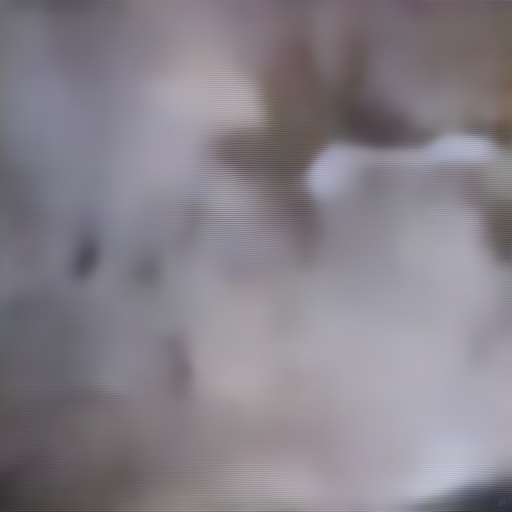

torch.Size([1, 3, 512, 512])

In [21]:
from PIL import Image
index = 65
low_level_img_path = f'/root/autodl-tmp/BrainAligning/vae_imgs/epoch_170/reconstructed_image_{index}_20.png'
# Provides low-level images 
low_level_image = Image.open(low_level_img_path)
low_level_image.show()
low_level_image = clip_encoder.preprocess(low_level_image, return_tensors="pt").pixel_values # [1, 3, 224, 224]
low_level_image.shape

In [54]:
from diffusers.image_processor import VaeImageProcessor
image_processor = VaeImageProcessor()
from diffusers import AutoencoderKL
# path = "stabilityai/sdxl-turbo"
# vlmodel = AutoencoderKL.from_pretrained(
#     path, subfolder='vae').to(device)

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float, variant="fp16")
vlmodel = pipe.vae

posterior = vlmodel.encode(low_level_image).latent_dist
image_latent = posterior.mode()
print("image_latent.shape", image_latent.shape)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
#generator setup
generator = Generator4Embeds(num_inference_steps=4, device=device)
# set a seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/thagafhh/work/.venv/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
diffusion_prior_mine = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)

# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))

pipe = Pipe(diffusion_prior, device=device)
pipe_my_weights = Pipe(diffusion_prior_mine, device=device)

# pipe_dreamsim_weights = Pipe(diffusion_prior, device=device)

pipe.diffusion_prior.load_state_dict(torch.load(f'/ibex/user/thagafhh/data/fintune_ckpts/sub-08/diffusion_prior.pt', map_location=device))
pipe_my_weights.diffusion_prior.load_state_dict(torch.load(f'/ibex/user/thagafhh/data/diffusion_states/fintune_ckpts/ATMS/sub-08/diffusion_prior.pt'))

# pipe_dreamsim_weights.diffusion_prior.load_state_dict(torch.load(f'/ibex/user/thagafhh/data/diffusion_states/fintune_ckpts/ATMS/sub-08/diffusion_prior'))


pipes = []

pipes.append({
    'pipe': pipe,
    'name': 'their diffusion weights'
})

pipes.append({
    'pipe': pipe_my_weights,
    'name': 'my diffusion weights'
})



9675648


In [ ]:
import os
from PIL import Image
from tqdm.notebook import tqdm # Use notebook-friendly tqdm for a nice progress bar

# --- 1. Setup the Output Directory ---
# Define the name of the directory where images will be saved.
output_dir = "/ibex/user/thagafhh/data/reconstruction_results/with_class_name"

# Create the directory. `exist_ok=True` prevents an error if the directory already exists.
os.makedirs(output_dir, exist_ok=True)
print(f"Images will be saved in the '{output_dir}/' directory.")

# --- 2. The Main Generation and Saving Loop ---
# We use tqdm to wrap the range for a progress bar.
for index in tqdm(range(len(images)), desc="Generating and Saving Images"):
    
    # for each eeg signal generate 10 images

    class_dir = os.path.join(output_dir, texts[index])
    os.makedirs(class_dir, exist_ok=True)

    # --- A. Ground Truth Image ---
    try:
        # Load the ground truth image from its path
        gt_image_path = images[index]
        gt_image = Image.open(gt_image_path)
        
        # Define a descriptive filename
        gt_filename = f"sample_{texts[index]}_ground_truth.png"
        gt_save_path = os.path.join(class_dir, gt_filename)
        
        # Save the image
        gt_image.save(gt_save_path)
        # print(f"Saved: {gt_save_path}")

    except Exception as e:
        print(f"Could not save ground truth for index {index}. Error: {e}")

    # --- B. Reconstruction with NEW Embeddings ---
    try:
        for i in range(10):
            if i < 5:
                # Generate the high-level features from your new EEG embeddings
                high_level_features_new = pipe_my_weights.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)
                
                # Generate the final image
                image_new = generator.generate(high_level_features_new, generator=gen)
                
                # Define a descriptive filename
                new_filename = f"sample_{i}_{texts[index]}_reconstruction_normal.png"
                new_save_path = os.path.join(class_dir, new_filename)
                
                # Save the image
                image_new.save(new_save_path)
                # print(f"Saved: {new_save_path}")
            else:
                # Generate the high-level features from your new EEG embeddings
                high_level_features_new = pipe_my_weights.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)
                
                # Generate the final image
                image_new = generator.generate(high_level_features_new, generator=gen, text_prompt=texts[index])
                
                # Define a descriptive filename
                new_filename = f"sample_{i}_{texts[index]}_reconstruction_withtext.png"
                new_save_path = os.path.join(class_dir, new_filename)
                
                # Save the image
                image_new.save(new_save_path)
                # print(f"Saved: {new_save_path}")


    except Exception as e:
        print(f"Could not generate/save 'new' reconstruction for index {index}. Error: {e}")

    # # --- C. Reconstruction with OLD Embeddings ---
    # try:
    #     # Generate the high-level features from the paper's old EEG embeddings
    #     high_level_features_old = pipe_my_weights.generate(c_embeds=old_eeg[index], num_inference_steps=10, guidance_scale=2.0)
        
    #     # Generate the final image
    #     image_old = generator.generate(high_level_features_old, generator=gen)
        
    #     # Define a descriptive filename
    #     old_filename = f"sample_{texts[index]}_reconstruction_old.png"
    #     old_save_path = os.path.join(class_dir, old_filename)
        
    #     # Save the image
    #     image_old.save(old_save_path)
    #     print(f"Saved: {old_save_path}")

    # except Exception as e:
    #     print(f"Could not generate/save 'old' reconstruction for index {index}. Error: {e}")

print("\n--- All images have been generated and saved. ---")

Images will be saved in the '/ibex/user/thagafhh/data/reconstruction_results/with_class_name/' directory.


Generating and Saving Images:   0%|          | 0/200 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_aircraft_carrier_ground_truth.png


10it [00:00, 45.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_0_aircraft_carrier_reconstruction_normal.png


10it [00:00, 213.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_1_aircraft_carrier_reconstruction_normal.png


10it [00:00, 211.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_2_aircraft_carrier_reconstruction_normal.png


10it [00:00, 211.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_3_aircraft_carrier_reconstruction_normal.png


10it [00:00, 211.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_4_aircraft_carrier_reconstruction_normal.png


10it [00:00, 212.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_5_aircraft_carrier_reconstruction_withtext.png


10it [00:00, 211.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_6_aircraft_carrier_reconstruction_withtext.png


10it [00:00, 210.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_7_aircraft_carrier_reconstruction_withtext.png


10it [00:00, 209.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_8_aircraft_carrier_reconstruction_withtext.png


10it [00:00, 213.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/aircraft_carrier/sample_9_aircraft_carrier_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_antelope_ground_truth.png


10it [00:00, 212.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_0_antelope_reconstruction_normal.png


10it [00:00, 209.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_1_antelope_reconstruction_normal.png


10it [00:00, 210.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_2_antelope_reconstruction_normal.png


10it [00:00, 211.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_3_antelope_reconstruction_normal.png


10it [00:00, 211.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_4_antelope_reconstruction_normal.png


10it [00:00, 212.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_5_antelope_reconstruction_withtext.png


10it [00:00, 213.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_6_antelope_reconstruction_withtext.png


10it [00:00, 214.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_7_antelope_reconstruction_withtext.png


10it [00:00, 212.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_8_antelope_reconstruction_withtext.png


10it [00:00, 212.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/antelope/sample_9_antelope_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_backscratcher_ground_truth.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_0_backscratcher_reconstruction_normal.png


10it [00:00, 208.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_1_backscratcher_reconstruction_normal.png


10it [00:00, 210.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_2_backscratcher_reconstruction_normal.png


10it [00:00, 209.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_3_backscratcher_reconstruction_normal.png


10it [00:00, 212.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_4_backscratcher_reconstruction_normal.png


10it [00:00, 209.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_5_backscratcher_reconstruction_withtext.png


10it [00:00, 210.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_6_backscratcher_reconstruction_withtext.png


10it [00:00, 211.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_7_backscratcher_reconstruction_withtext.png


10it [00:00, 210.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_8_backscratcher_reconstruction_withtext.png


10it [00:00, 207.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/backscratcher/sample_9_backscratcher_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_balance_beam_ground_truth.png


10it [00:00, 209.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_0_balance_beam_reconstruction_normal.png


10it [00:00, 208.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_1_balance_beam_reconstruction_normal.png


10it [00:00, 206.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_2_balance_beam_reconstruction_normal.png


10it [00:00, 208.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_3_balance_beam_reconstruction_normal.png


10it [00:00, 211.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_4_balance_beam_reconstruction_normal.png


10it [00:00, 210.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_5_balance_beam_reconstruction_withtext.png


10it [00:00, 212.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_6_balance_beam_reconstruction_withtext.png


10it [00:00, 210.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_7_balance_beam_reconstruction_withtext.png


10it [00:00, 210.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_8_balance_beam_reconstruction_withtext.png


10it [00:00, 212.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/balance_beam/sample_9_balance_beam_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_banana_ground_truth.png


10it [00:00, 211.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_0_banana_reconstruction_normal.png


10it [00:00, 211.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_1_banana_reconstruction_normal.png


10it [00:00, 209.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_2_banana_reconstruction_normal.png


10it [00:00, 211.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_3_banana_reconstruction_normal.png


10it [00:00, 210.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_4_banana_reconstruction_normal.png


10it [00:00, 209.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_5_banana_reconstruction_withtext.png


10it [00:00, 208.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_6_banana_reconstruction_withtext.png


10it [00:00, 207.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_7_banana_reconstruction_withtext.png


10it [00:00, 210.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_8_banana_reconstruction_withtext.png


10it [00:00, 208.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/banana/sample_9_banana_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_baseball_bat_ground_truth.png


10it [00:00, 209.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_0_baseball_bat_reconstruction_normal.png


10it [00:00, 212.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_1_baseball_bat_reconstruction_normal.png


10it [00:00, 212.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_2_baseball_bat_reconstruction_normal.png


10it [00:00, 209.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_3_baseball_bat_reconstruction_normal.png


10it [00:00, 208.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_4_baseball_bat_reconstruction_normal.png


10it [00:00, 209.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_5_baseball_bat_reconstruction_withtext.png


10it [00:00, 206.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_6_baseball_bat_reconstruction_withtext.png


10it [00:00, 205.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_7_baseball_bat_reconstruction_withtext.png


10it [00:00, 206.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_8_baseball_bat_reconstruction_withtext.png


10it [00:00, 208.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baseball_bat/sample_9_baseball_bat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_basil_ground_truth.png


10it [00:00, 210.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_0_basil_reconstruction_normal.png


10it [00:00, 201.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_1_basil_reconstruction_normal.png


10it [00:00, 210.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_2_basil_reconstruction_normal.png


10it [00:00, 209.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_3_basil_reconstruction_normal.png


10it [00:00, 211.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_4_basil_reconstruction_normal.png


10it [00:00, 207.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_5_basil_reconstruction_withtext.png


10it [00:00, 206.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_6_basil_reconstruction_withtext.png


10it [00:00, 210.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_7_basil_reconstruction_withtext.png


10it [00:00, 208.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_8_basil_reconstruction_withtext.png


10it [00:00, 208.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basil/sample_9_basil_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_basketball_ground_truth.png


10it [00:00, 207.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_0_basketball_reconstruction_normal.png


10it [00:00, 208.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_1_basketball_reconstruction_normal.png


10it [00:00, 210.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_2_basketball_reconstruction_normal.png


10it [00:00, 207.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_3_basketball_reconstruction_normal.png


10it [00:00, 207.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_4_basketball_reconstruction_normal.png


10it [00:00, 208.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_5_basketball_reconstruction_withtext.png


10it [00:00, 208.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_6_basketball_reconstruction_withtext.png


10it [00:00, 205.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_7_basketball_reconstruction_withtext.png


10it [00:00, 210.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_8_basketball_reconstruction_withtext.png


10it [00:00, 206.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/basketball/sample_9_basketball_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_bassoon_ground_truth.png


10it [00:00, 203.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_0_bassoon_reconstruction_normal.png


10it [00:00, 207.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_1_bassoon_reconstruction_normal.png


10it [00:00, 206.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_2_bassoon_reconstruction_normal.png


10it [00:00, 209.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_3_bassoon_reconstruction_normal.png


10it [00:00, 208.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_4_bassoon_reconstruction_normal.png


10it [00:00, 208.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_5_bassoon_reconstruction_withtext.png


10it [00:00, 207.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_6_bassoon_reconstruction_withtext.png


10it [00:00, 206.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_7_bassoon_reconstruction_withtext.png


10it [00:00, 205.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_8_bassoon_reconstruction_withtext.png


10it [00:00, 207.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bassoon/sample_9_bassoon_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_baton4_ground_truth.png


10it [00:00, 205.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_0_baton4_reconstruction_normal.png


10it [00:00, 205.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_1_baton4_reconstruction_normal.png


10it [00:00, 207.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_2_baton4_reconstruction_normal.png


10it [00:00, 205.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_3_baton4_reconstruction_normal.png


10it [00:00, 205.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_4_baton4_reconstruction_normal.png


10it [00:00, 207.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_5_baton4_reconstruction_withtext.png


10it [00:00, 207.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_6_baton4_reconstruction_withtext.png


10it [00:00, 207.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_7_baton4_reconstruction_withtext.png


10it [00:00, 205.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_8_baton4_reconstruction_withtext.png


10it [00:00, 207.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/baton4/sample_9_baton4_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_batter_ground_truth.png


10it [00:00, 205.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_0_batter_reconstruction_normal.png


10it [00:00, 207.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_1_batter_reconstruction_normal.png


10it [00:00, 210.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_2_batter_reconstruction_normal.png


10it [00:00, 210.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_3_batter_reconstruction_normal.png


10it [00:00, 208.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_4_batter_reconstruction_normal.png


10it [00:00, 210.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_5_batter_reconstruction_withtext.png


10it [00:00, 208.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_6_batter_reconstruction_withtext.png


10it [00:00, 210.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_7_batter_reconstruction_withtext.png


10it [00:00, 212.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_8_batter_reconstruction_withtext.png


10it [00:00, 210.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/batter/sample_9_batter_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_beaver_ground_truth.png


10it [00:00, 210.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_0_beaver_reconstruction_normal.png


10it [00:00, 209.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_1_beaver_reconstruction_normal.png


10it [00:00, 212.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_2_beaver_reconstruction_normal.png


10it [00:00, 211.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_3_beaver_reconstruction_normal.png


10it [00:00, 212.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_4_beaver_reconstruction_normal.png


10it [00:00, 204.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_5_beaver_reconstruction_withtext.png


10it [00:00, 208.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_6_beaver_reconstruction_withtext.png


10it [00:00, 212.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_7_beaver_reconstruction_withtext.png


10it [00:00, 207.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_8_beaver_reconstruction_withtext.png


10it [00:00, 207.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/beaver/sample_9_beaver_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_bench_ground_truth.png


10it [00:00, 208.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_0_bench_reconstruction_normal.png


10it [00:00, 208.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_1_bench_reconstruction_normal.png


10it [00:00, 206.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_2_bench_reconstruction_normal.png


10it [00:00, 205.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_3_bench_reconstruction_normal.png


10it [00:00, 207.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_4_bench_reconstruction_normal.png


10it [00:00, 206.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_5_bench_reconstruction_withtext.png


10it [00:00, 205.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_6_bench_reconstruction_withtext.png


10it [00:00, 206.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_7_bench_reconstruction_withtext.png


10it [00:00, 205.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_8_bench_reconstruction_withtext.png


10it [00:00, 208.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bench/sample_9_bench_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_bike_ground_truth.png


10it [00:00, 205.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_0_bike_reconstruction_normal.png


10it [00:00, 208.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_1_bike_reconstruction_normal.png


10it [00:00, 208.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_2_bike_reconstruction_normal.png


10it [00:00, 207.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_3_bike_reconstruction_normal.png


10it [00:00, 207.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_4_bike_reconstruction_normal.png


10it [00:00, 206.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_5_bike_reconstruction_withtext.png


10it [00:00, 205.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_6_bike_reconstruction_withtext.png


10it [00:00, 211.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_7_bike_reconstruction_withtext.png


10it [00:00, 209.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_8_bike_reconstruction_withtext.png


10it [00:00, 209.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bike/sample_9_bike_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_birthday_cake_ground_truth.png


10it [00:00, 209.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_0_birthday_cake_reconstruction_normal.png


10it [00:00, 209.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_1_birthday_cake_reconstruction_normal.png


10it [00:00, 206.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_2_birthday_cake_reconstruction_normal.png


10it [00:00, 209.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_3_birthday_cake_reconstruction_normal.png


10it [00:00, 208.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_4_birthday_cake_reconstruction_normal.png


10it [00:00, 210.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_5_birthday_cake_reconstruction_withtext.png


10it [00:00, 210.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_6_birthday_cake_reconstruction_withtext.png


10it [00:00, 209.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_7_birthday_cake_reconstruction_withtext.png


10it [00:00, 210.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_8_birthday_cake_reconstruction_withtext.png


10it [00:00, 209.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/birthday_cake/sample_9_birthday_cake_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_blowtorch_ground_truth.png


10it [00:00, 209.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_0_blowtorch_reconstruction_normal.png


10it [00:00, 204.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_1_blowtorch_reconstruction_normal.png


10it [00:00, 203.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_2_blowtorch_reconstruction_normal.png


10it [00:00, 210.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_3_blowtorch_reconstruction_normal.png


10it [00:00, 211.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_4_blowtorch_reconstruction_normal.png


10it [00:00, 209.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_5_blowtorch_reconstruction_withtext.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_6_blowtorch_reconstruction_withtext.png


10it [00:00, 209.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_7_blowtorch_reconstruction_withtext.png


10it [00:00, 210.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_8_blowtorch_reconstruction_withtext.png


10it [00:00, 208.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/blowtorch/sample_9_blowtorch_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_boat_ground_truth.png


10it [00:00, 207.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_0_boat_reconstruction_normal.png


10it [00:00, 209.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_1_boat_reconstruction_normal.png


10it [00:00, 208.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_2_boat_reconstruction_normal.png


10it [00:00, 210.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_3_boat_reconstruction_normal.png


10it [00:00, 206.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_4_boat_reconstruction_normal.png


10it [00:00, 208.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_5_boat_reconstruction_withtext.png


10it [00:00, 211.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_6_boat_reconstruction_withtext.png


10it [00:00, 211.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_7_boat_reconstruction_withtext.png


10it [00:00, 210.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_8_boat_reconstruction_withtext.png


10it [00:00, 207.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/boat/sample_9_boat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_bok_choy_ground_truth.png


10it [00:00, 210.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_0_bok_choy_reconstruction_normal.png


10it [00:00, 211.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_1_bok_choy_reconstruction_normal.png


10it [00:00, 209.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_2_bok_choy_reconstruction_normal.png


10it [00:00, 208.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_3_bok_choy_reconstruction_normal.png


10it [00:00, 205.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_4_bok_choy_reconstruction_normal.png


10it [00:00, 208.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_5_bok_choy_reconstruction_withtext.png


10it [00:00, 208.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_6_bok_choy_reconstruction_withtext.png


10it [00:00, 210.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_7_bok_choy_reconstruction_withtext.png


10it [00:00, 209.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_8_bok_choy_reconstruction_withtext.png


10it [00:00, 210.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bok_choy/sample_9_bok_choy_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_bonnet_ground_truth.png


10it [00:00, 210.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_0_bonnet_reconstruction_normal.png


10it [00:00, 209.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_1_bonnet_reconstruction_normal.png


10it [00:00, 210.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_2_bonnet_reconstruction_normal.png


10it [00:00, 210.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_3_bonnet_reconstruction_normal.png


10it [00:00, 209.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_4_bonnet_reconstruction_normal.png


10it [00:00, 210.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_5_bonnet_reconstruction_withtext.png


10it [00:00, 208.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_6_bonnet_reconstruction_withtext.png


10it [00:00, 210.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_7_bonnet_reconstruction_withtext.png


10it [00:00, 208.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_8_bonnet_reconstruction_withtext.png


10it [00:00, 209.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bonnet/sample_9_bonnet_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_bottle_opener_ground_truth.png


10it [00:00, 208.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_0_bottle_opener_reconstruction_normal.png


10it [00:00, 209.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_1_bottle_opener_reconstruction_normal.png


10it [00:00, 208.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_2_bottle_opener_reconstruction_normal.png


10it [00:00, 208.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_3_bottle_opener_reconstruction_normal.png


10it [00:00, 209.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_4_bottle_opener_reconstruction_normal.png


10it [00:00, 210.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_5_bottle_opener_reconstruction_withtext.png


10it [00:00, 209.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_6_bottle_opener_reconstruction_withtext.png


10it [00:00, 209.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_7_bottle_opener_reconstruction_withtext.png


10it [00:00, 209.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_8_bottle_opener_reconstruction_withtext.png


10it [00:00, 210.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bottle_opener/sample_9_bottle_opener_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_brace_ground_truth.png


10it [00:00, 206.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_0_brace_reconstruction_normal.png


10it [00:00, 209.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_1_brace_reconstruction_normal.png


10it [00:00, 207.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_2_brace_reconstruction_normal.png


10it [00:00, 209.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_3_brace_reconstruction_normal.png


10it [00:00, 207.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_4_brace_reconstruction_normal.png


10it [00:00, 207.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_5_brace_reconstruction_withtext.png


10it [00:00, 211.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_6_brace_reconstruction_withtext.png


10it [00:00, 210.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_7_brace_reconstruction_withtext.png


10it [00:00, 211.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_8_brace_reconstruction_withtext.png


10it [00:00, 210.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/brace/sample_9_brace_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_bread_ground_truth.png


10it [00:00, 208.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_0_bread_reconstruction_normal.png


10it [00:00, 209.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_1_bread_reconstruction_normal.png


10it [00:00, 209.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_2_bread_reconstruction_normal.png


10it [00:00, 203.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_3_bread_reconstruction_normal.png


10it [00:00, 210.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_4_bread_reconstruction_normal.png


10it [00:00, 211.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_5_bread_reconstruction_withtext.png


10it [00:00, 201.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_6_bread_reconstruction_withtext.png


10it [00:00, 206.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_7_bread_reconstruction_withtext.png


10it [00:00, 207.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_8_bread_reconstruction_withtext.png


10it [00:00, 205.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bread/sample_9_bread_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_breadbox_ground_truth.png


10it [00:00, 209.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_0_breadbox_reconstruction_normal.png


10it [00:00, 208.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_1_breadbox_reconstruction_normal.png


10it [00:00, 209.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_2_breadbox_reconstruction_normal.png


10it [00:00, 210.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_3_breadbox_reconstruction_normal.png


10it [00:00, 204.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_4_breadbox_reconstruction_normal.png


10it [00:00, 211.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_5_breadbox_reconstruction_withtext.png


10it [00:00, 206.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_6_breadbox_reconstruction_withtext.png


10it [00:00, 206.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_7_breadbox_reconstruction_withtext.png


10it [00:00, 208.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_8_breadbox_reconstruction_withtext.png


10it [00:00, 208.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/breadbox/sample_9_breadbox_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_bug_ground_truth.png


10it [00:00, 205.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_0_bug_reconstruction_normal.png


10it [00:00, 210.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_1_bug_reconstruction_normal.png


10it [00:00, 210.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_2_bug_reconstruction_normal.png


10it [00:00, 210.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_3_bug_reconstruction_normal.png


10it [00:00, 209.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_4_bug_reconstruction_normal.png


10it [00:00, 211.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_5_bug_reconstruction_withtext.png


10it [00:00, 205.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_6_bug_reconstruction_withtext.png


10it [00:00, 207.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_7_bug_reconstruction_withtext.png


10it [00:00, 205.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_8_bug_reconstruction_withtext.png


10it [00:00, 205.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bug/sample_9_bug_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_buggy_ground_truth.png


10it [00:00, 206.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_0_buggy_reconstruction_normal.png


10it [00:00, 206.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_1_buggy_reconstruction_normal.png


10it [00:00, 207.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_2_buggy_reconstruction_normal.png


10it [00:00, 206.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_3_buggy_reconstruction_normal.png


10it [00:00, 207.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_4_buggy_reconstruction_normal.png


10it [00:00, 207.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_5_buggy_reconstruction_withtext.png


10it [00:00, 206.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_6_buggy_reconstruction_withtext.png


10it [00:00, 204.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_7_buggy_reconstruction_withtext.png


10it [00:00, 204.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_8_buggy_reconstruction_withtext.png


10it [00:00, 206.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/buggy/sample_9_buggy_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_bullet_ground_truth.png


10it [00:00, 209.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_0_bullet_reconstruction_normal.png


10it [00:00, 202.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_1_bullet_reconstruction_normal.png


10it [00:00, 205.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_2_bullet_reconstruction_normal.png


10it [00:00, 211.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_3_bullet_reconstruction_normal.png


10it [00:00, 211.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_4_bullet_reconstruction_normal.png


10it [00:00, 205.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_5_bullet_reconstruction_withtext.png


10it [00:00, 207.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_6_bullet_reconstruction_withtext.png


10it [00:00, 207.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_7_bullet_reconstruction_withtext.png


10it [00:00, 204.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_8_bullet_reconstruction_withtext.png


10it [00:00, 206.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bullet/sample_9_bullet_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_bun_ground_truth.png


10it [00:00, 203.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_0_bun_reconstruction_normal.png


10it [00:00, 208.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_1_bun_reconstruction_normal.png


10it [00:00, 205.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_2_bun_reconstruction_normal.png


10it [00:00, 204.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_3_bun_reconstruction_normal.png


10it [00:00, 206.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_4_bun_reconstruction_normal.png


10it [00:00, 204.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_5_bun_reconstruction_withtext.png


10it [00:00, 210.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_6_bun_reconstruction_withtext.png


10it [00:00, 210.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_7_bun_reconstruction_withtext.png


10it [00:00, 205.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_8_bun_reconstruction_withtext.png


10it [00:00, 207.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bun/sample_9_bun_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_bush_ground_truth.png


10it [00:00, 205.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_0_bush_reconstruction_normal.png


10it [00:00, 209.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_1_bush_reconstruction_normal.png


10it [00:00, 208.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_2_bush_reconstruction_normal.png


10it [00:00, 206.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_3_bush_reconstruction_normal.png


10it [00:00, 210.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_4_bush_reconstruction_normal.png


10it [00:00, 210.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_5_bush_reconstruction_withtext.png


10it [00:00, 206.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_6_bush_reconstruction_withtext.png


10it [00:00, 206.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_7_bush_reconstruction_withtext.png


10it [00:00, 209.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_8_bush_reconstruction_withtext.png


10it [00:00, 209.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/bush/sample_9_bush_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_calamari_ground_truth.png


10it [00:00, 206.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_0_calamari_reconstruction_normal.png


10it [00:00, 206.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_1_calamari_reconstruction_normal.png


10it [00:00, 205.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_2_calamari_reconstruction_normal.png


10it [00:00, 206.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_3_calamari_reconstruction_normal.png


10it [00:00, 204.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_4_calamari_reconstruction_normal.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_5_calamari_reconstruction_withtext.png


10it [00:00, 206.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_6_calamari_reconstruction_withtext.png


10it [00:00, 205.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_7_calamari_reconstruction_withtext.png


10it [00:00, 208.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_8_calamari_reconstruction_withtext.png


10it [00:00, 208.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/calamari/sample_9_calamari_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_candlestick_ground_truth.png


10it [00:00, 209.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_0_candlestick_reconstruction_normal.png


10it [00:00, 210.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_1_candlestick_reconstruction_normal.png


10it [00:00, 210.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_2_candlestick_reconstruction_normal.png


10it [00:00, 208.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_3_candlestick_reconstruction_normal.png


10it [00:00, 206.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_4_candlestick_reconstruction_normal.png


10it [00:00, 208.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_5_candlestick_reconstruction_withtext.png


10it [00:00, 207.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_6_candlestick_reconstruction_withtext.png


10it [00:00, 208.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_7_candlestick_reconstruction_withtext.png


10it [00:00, 209.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_8_candlestick_reconstruction_withtext.png


10it [00:00, 210.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/candlestick/sample_9_candlestick_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_cart_ground_truth.png


10it [00:00, 211.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_0_cart_reconstruction_normal.png


10it [00:00, 209.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_1_cart_reconstruction_normal.png


10it [00:00, 208.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_2_cart_reconstruction_normal.png


10it [00:00, 210.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_3_cart_reconstruction_normal.png


10it [00:00, 209.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_4_cart_reconstruction_normal.png


10it [00:00, 211.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_5_cart_reconstruction_withtext.png


10it [00:00, 202.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_6_cart_reconstruction_withtext.png


10it [00:00, 210.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_7_cart_reconstruction_withtext.png


10it [00:00, 209.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_8_cart_reconstruction_withtext.png


10it [00:00, 210.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cart/sample_9_cart_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_cashew_ground_truth.png


10it [00:00, 209.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_0_cashew_reconstruction_normal.png


10it [00:00, 209.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_1_cashew_reconstruction_normal.png


10it [00:00, 209.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_2_cashew_reconstruction_normal.png


10it [00:00, 208.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_3_cashew_reconstruction_normal.png


10it [00:00, 207.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_4_cashew_reconstruction_normal.png


10it [00:00, 210.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_5_cashew_reconstruction_withtext.png


10it [00:00, 208.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_6_cashew_reconstruction_withtext.png


10it [00:00, 209.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_7_cashew_reconstruction_withtext.png


10it [00:00, 210.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_8_cashew_reconstruction_withtext.png


10it [00:00, 209.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cashew/sample_9_cashew_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_cat_ground_truth.png


10it [00:00, 204.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_0_cat_reconstruction_normal.png


10it [00:00, 207.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_1_cat_reconstruction_normal.png


10it [00:00, 205.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_2_cat_reconstruction_normal.png


10it [00:00, 206.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_3_cat_reconstruction_normal.png


10it [00:00, 203.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_4_cat_reconstruction_normal.png


10it [00:00, 205.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_5_cat_reconstruction_withtext.png


10it [00:00, 208.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_6_cat_reconstruction_withtext.png


10it [00:00, 211.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_7_cat_reconstruction_withtext.png


10it [00:00, 209.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_8_cat_reconstruction_withtext.png


10it [00:00, 209.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cat/sample_9_cat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_caterpillar_ground_truth.png


10it [00:00, 207.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_0_caterpillar_reconstruction_normal.png


10it [00:00, 208.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_1_caterpillar_reconstruction_normal.png


10it [00:00, 206.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_2_caterpillar_reconstruction_normal.png


10it [00:00, 210.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_3_caterpillar_reconstruction_normal.png


10it [00:00, 210.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_4_caterpillar_reconstruction_normal.png


10it [00:00, 208.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_5_caterpillar_reconstruction_withtext.png


10it [00:00, 208.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_6_caterpillar_reconstruction_withtext.png


10it [00:00, 207.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_7_caterpillar_reconstruction_withtext.png


10it [00:00, 208.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_8_caterpillar_reconstruction_withtext.png


10it [00:00, 208.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/caterpillar/sample_9_caterpillar_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_cd_player_ground_truth.png


10it [00:00, 208.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_0_cd_player_reconstruction_normal.png


10it [00:00, 209.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_1_cd_player_reconstruction_normal.png


10it [00:00, 211.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_2_cd_player_reconstruction_normal.png


10it [00:00, 208.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_3_cd_player_reconstruction_normal.png


10it [00:00, 210.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_4_cd_player_reconstruction_normal.png


10it [00:00, 208.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_5_cd_player_reconstruction_withtext.png


10it [00:00, 207.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_6_cd_player_reconstruction_withtext.png


10it [00:00, 206.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_7_cd_player_reconstruction_withtext.png


10it [00:00, 204.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_8_cd_player_reconstruction_withtext.png


10it [00:00, 207.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cd_player/sample_9_cd_player_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_chain_ground_truth.png


10it [00:00, 204.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_0_chain_reconstruction_normal.png


10it [00:00, 209.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_1_chain_reconstruction_normal.png


10it [00:00, 211.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_2_chain_reconstruction_normal.png


10it [00:00, 207.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_3_chain_reconstruction_normal.png


10it [00:00, 205.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_4_chain_reconstruction_normal.png


10it [00:00, 206.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_5_chain_reconstruction_withtext.png


10it [00:00, 206.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_6_chain_reconstruction_withtext.png


10it [00:00, 201.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_7_chain_reconstruction_withtext.png


10it [00:00, 204.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_8_chain_reconstruction_withtext.png


10it [00:00, 206.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chain/sample_9_chain_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_chaps_ground_truth.png


10it [00:00, 205.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_0_chaps_reconstruction_normal.png


10it [00:00, 206.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_1_chaps_reconstruction_normal.png


10it [00:00, 209.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_2_chaps_reconstruction_normal.png


10it [00:00, 209.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_3_chaps_reconstruction_normal.png


10it [00:00, 209.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_4_chaps_reconstruction_normal.png


10it [00:00, 210.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_5_chaps_reconstruction_withtext.png


10it [00:00, 208.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_6_chaps_reconstruction_withtext.png


10it [00:00, 208.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_7_chaps_reconstruction_withtext.png


10it [00:00, 207.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_8_chaps_reconstruction_withtext.png


10it [00:00, 209.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chaps/sample_9_chaps_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_cheese_ground_truth.png


10it [00:00, 208.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_0_cheese_reconstruction_normal.png


10it [00:00, 208.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_1_cheese_reconstruction_normal.png


10it [00:00, 209.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_2_cheese_reconstruction_normal.png


10it [00:00, 210.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_3_cheese_reconstruction_normal.png


10it [00:00, 208.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_4_cheese_reconstruction_normal.png


10it [00:00, 210.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_5_cheese_reconstruction_withtext.png


10it [00:00, 209.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_6_cheese_reconstruction_withtext.png


10it [00:00, 205.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_7_cheese_reconstruction_withtext.png


10it [00:00, 205.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_8_cheese_reconstruction_withtext.png


10it [00:00, 204.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheese/sample_9_cheese_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_cheetah_ground_truth.png


10it [00:00, 204.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_0_cheetah_reconstruction_normal.png


10it [00:00, 208.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_1_cheetah_reconstruction_normal.png


10it [00:00, 208.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_2_cheetah_reconstruction_normal.png


10it [00:00, 205.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_3_cheetah_reconstruction_normal.png


10it [00:00, 205.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_4_cheetah_reconstruction_normal.png


10it [00:00, 205.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_5_cheetah_reconstruction_withtext.png


10it [00:00, 207.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_6_cheetah_reconstruction_withtext.png


10it [00:00, 205.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_7_cheetah_reconstruction_withtext.png


10it [00:00, 206.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_8_cheetah_reconstruction_withtext.png


10it [00:00, 207.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cheetah/sample_9_cheetah_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_chest2_ground_truth.png


10it [00:00, 210.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_0_chest2_reconstruction_normal.png


10it [00:00, 208.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_1_chest2_reconstruction_normal.png


10it [00:00, 204.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_2_chest2_reconstruction_normal.png


10it [00:00, 207.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_3_chest2_reconstruction_normal.png


10it [00:00, 207.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_4_chest2_reconstruction_normal.png


10it [00:00, 206.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_5_chest2_reconstruction_withtext.png


10it [00:00, 204.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_6_chest2_reconstruction_withtext.png


10it [00:00, 204.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_7_chest2_reconstruction_withtext.png


10it [00:00, 206.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_8_chest2_reconstruction_withtext.png


10it [00:00, 205.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chest2/sample_9_chest2_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_chime_ground_truth.png


10it [00:00, 205.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_0_chime_reconstruction_normal.png


10it [00:00, 209.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_1_chime_reconstruction_normal.png


10it [00:00, 207.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_2_chime_reconstruction_normal.png


10it [00:00, 207.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_3_chime_reconstruction_normal.png


10it [00:00, 204.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_4_chime_reconstruction_normal.png


10it [00:00, 205.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_5_chime_reconstruction_withtext.png


10it [00:00, 205.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_6_chime_reconstruction_withtext.png


10it [00:00, 206.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_7_chime_reconstruction_withtext.png


10it [00:00, 204.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_8_chime_reconstruction_withtext.png


10it [00:00, 205.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chime/sample_9_chime_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_chopsticks_ground_truth.png


10it [00:00, 206.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_0_chopsticks_reconstruction_normal.png


10it [00:00, 205.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_1_chopsticks_reconstruction_normal.png


10it [00:00, 206.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_2_chopsticks_reconstruction_normal.png


10it [00:00, 206.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_3_chopsticks_reconstruction_normal.png


10it [00:00, 210.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_4_chopsticks_reconstruction_normal.png


10it [00:00, 210.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_5_chopsticks_reconstruction_withtext.png


10it [00:00, 206.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_6_chopsticks_reconstruction_withtext.png


10it [00:00, 206.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_7_chopsticks_reconstruction_withtext.png


10it [00:00, 208.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_8_chopsticks_reconstruction_withtext.png


10it [00:00, 209.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/chopsticks/sample_9_chopsticks_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_cleat_ground_truth.png


10it [00:00, 207.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_0_cleat_reconstruction_normal.png


10it [00:00, 210.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_1_cleat_reconstruction_normal.png


10it [00:00, 209.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_2_cleat_reconstruction_normal.png


10it [00:00, 205.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_3_cleat_reconstruction_normal.png


10it [00:00, 209.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_4_cleat_reconstruction_normal.png


10it [00:00, 205.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_5_cleat_reconstruction_withtext.png


10it [00:00, 204.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_6_cleat_reconstruction_withtext.png


10it [00:00, 205.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_7_cleat_reconstruction_withtext.png


10it [00:00, 204.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_8_cleat_reconstruction_withtext.png


10it [00:00, 205.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleat/sample_9_cleat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_cleaver_ground_truth.png


10it [00:00, 206.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_0_cleaver_reconstruction_normal.png


10it [00:00, 206.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_1_cleaver_reconstruction_normal.png


10it [00:00, 204.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_2_cleaver_reconstruction_normal.png


10it [00:00, 207.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_3_cleaver_reconstruction_normal.png


10it [00:00, 209.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_4_cleaver_reconstruction_normal.png


10it [00:00, 207.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_5_cleaver_reconstruction_withtext.png


10it [00:00, 205.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_6_cleaver_reconstruction_withtext.png


10it [00:00, 206.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_7_cleaver_reconstruction_withtext.png


10it [00:00, 204.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_8_cleaver_reconstruction_withtext.png


10it [00:00, 209.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cleaver/sample_9_cleaver_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_coat_ground_truth.png


10it [00:00, 204.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_0_coat_reconstruction_normal.png


10it [00:00, 208.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_1_coat_reconstruction_normal.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_2_coat_reconstruction_normal.png


10it [00:00, 208.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_3_coat_reconstruction_normal.png


10it [00:00, 207.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_4_coat_reconstruction_normal.png


10it [00:00, 205.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_5_coat_reconstruction_withtext.png


10it [00:00, 209.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_6_coat_reconstruction_withtext.png


10it [00:00, 204.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_7_coat_reconstruction_withtext.png


10it [00:00, 209.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_8_coat_reconstruction_withtext.png


10it [00:00, 206.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coat/sample_9_coat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_cobra_ground_truth.png


10it [00:00, 206.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_0_cobra_reconstruction_normal.png


10it [00:00, 207.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_1_cobra_reconstruction_normal.png


10it [00:00, 205.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_2_cobra_reconstruction_normal.png


10it [00:00, 205.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_3_cobra_reconstruction_normal.png


10it [00:00, 208.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_4_cobra_reconstruction_normal.png


10it [00:00, 205.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_5_cobra_reconstruction_withtext.png


10it [00:00, 208.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_6_cobra_reconstruction_withtext.png


10it [00:00, 206.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_7_cobra_reconstruction_withtext.png


10it [00:00, 208.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_8_cobra_reconstruction_withtext.png


10it [00:00, 210.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cobra/sample_9_cobra_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_coconut_ground_truth.png


10it [00:00, 207.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_0_coconut_reconstruction_normal.png


10it [00:00, 207.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_1_coconut_reconstruction_normal.png


10it [00:00, 206.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_2_coconut_reconstruction_normal.png


10it [00:00, 205.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_3_coconut_reconstruction_normal.png


10it [00:00, 207.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_4_coconut_reconstruction_normal.png


10it [00:00, 36.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_5_coconut_reconstruction_withtext.png


10it [00:00, 209.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_6_coconut_reconstruction_withtext.png


10it [00:00, 207.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_7_coconut_reconstruction_withtext.png


10it [00:00, 204.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_8_coconut_reconstruction_withtext.png


10it [00:00, 206.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coconut/sample_9_coconut_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_coffee_bean_ground_truth.png


10it [00:00, 206.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_0_coffee_bean_reconstruction_normal.png


10it [00:00, 209.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_1_coffee_bean_reconstruction_normal.png


10it [00:00, 206.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_2_coffee_bean_reconstruction_normal.png


10it [00:00, 206.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_3_coffee_bean_reconstruction_normal.png


10it [00:00, 206.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_4_coffee_bean_reconstruction_normal.png


10it [00:00, 210.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_5_coffee_bean_reconstruction_withtext.png


10it [00:00, 209.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_6_coffee_bean_reconstruction_withtext.png


10it [00:00, 206.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_7_coffee_bean_reconstruction_withtext.png


10it [00:00, 209.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_8_coffee_bean_reconstruction_withtext.png


10it [00:00, 207.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffee_bean/sample_9_coffee_bean_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_coffeemaker_ground_truth.png


10it [00:00, 208.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_0_coffeemaker_reconstruction_normal.png


10it [00:00, 206.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_1_coffeemaker_reconstruction_normal.png


10it [00:00, 203.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_2_coffeemaker_reconstruction_normal.png


10it [00:00, 205.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_3_coffeemaker_reconstruction_normal.png


10it [00:00, 205.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_4_coffeemaker_reconstruction_normal.png


10it [00:00, 206.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_5_coffeemaker_reconstruction_withtext.png


10it [00:00, 207.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_6_coffeemaker_reconstruction_withtext.png


10it [00:00, 206.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_7_coffeemaker_reconstruction_withtext.png


10it [00:00, 200.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_8_coffeemaker_reconstruction_withtext.png


10it [00:00, 207.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coffeemaker/sample_9_coffeemaker_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_cookie_ground_truth.png


10it [00:00, 201.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_0_cookie_reconstruction_normal.png


10it [00:00, 207.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_1_cookie_reconstruction_normal.png


10it [00:00, 209.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_2_cookie_reconstruction_normal.png


10it [00:00, 205.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_3_cookie_reconstruction_normal.png


10it [00:00, 205.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_4_cookie_reconstruction_normal.png


10it [00:00, 204.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_5_cookie_reconstruction_withtext.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_6_cookie_reconstruction_withtext.png


10it [00:00, 208.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_7_cookie_reconstruction_withtext.png


10it [00:00, 205.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_8_cookie_reconstruction_withtext.png


10it [00:00, 205.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cookie/sample_9_cookie_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_cordon_bleu_ground_truth.png


10it [00:00, 205.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_0_cordon_bleu_reconstruction_normal.png


10it [00:00, 205.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_1_cordon_bleu_reconstruction_normal.png


10it [00:00, 210.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_2_cordon_bleu_reconstruction_normal.png


10it [00:00, 207.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_3_cordon_bleu_reconstruction_normal.png


10it [00:00, 205.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_4_cordon_bleu_reconstruction_normal.png


10it [00:00, 206.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_5_cordon_bleu_reconstruction_withtext.png


10it [00:00, 206.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_6_cordon_bleu_reconstruction_withtext.png


10it [00:00, 206.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_7_cordon_bleu_reconstruction_withtext.png


10it [00:00, 209.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_8_cordon_bleu_reconstruction_withtext.png


10it [00:00, 209.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cordon_bleu/sample_9_cordon_bleu_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_coverall_ground_truth.png


10it [00:00, 204.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_0_coverall_reconstruction_normal.png


10it [00:00, 205.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_1_coverall_reconstruction_normal.png


10it [00:00, 205.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_2_coverall_reconstruction_normal.png


10it [00:00, 207.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_3_coverall_reconstruction_normal.png


10it [00:00, 206.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_4_coverall_reconstruction_normal.png


10it [00:00, 205.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_5_coverall_reconstruction_withtext.png


10it [00:00, 206.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_6_coverall_reconstruction_withtext.png


10it [00:00, 204.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_7_coverall_reconstruction_withtext.png


10it [00:00, 204.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_8_coverall_reconstruction_withtext.png


10it [00:00, 207.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/coverall/sample_9_coverall_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_crab_ground_truth.png


10it [00:00, 206.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_0_crab_reconstruction_normal.png


10it [00:00, 208.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_1_crab_reconstruction_normal.png


10it [00:00, 205.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_2_crab_reconstruction_normal.png


10it [00:00, 207.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_3_crab_reconstruction_normal.png


10it [00:00, 207.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_4_crab_reconstruction_normal.png


10it [00:00, 207.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_5_crab_reconstruction_withtext.png


10it [00:00, 204.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_6_crab_reconstruction_withtext.png


10it [00:00, 207.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_7_crab_reconstruction_withtext.png


10it [00:00, 209.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_8_crab_reconstruction_withtext.png


10it [00:00, 208.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crab/sample_9_crab_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_creme_brulee_ground_truth.png


10it [00:00, 204.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_0_creme_brulee_reconstruction_normal.png


10it [00:00, 207.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_1_creme_brulee_reconstruction_normal.png


10it [00:00, 210.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_2_creme_brulee_reconstruction_normal.png


10it [00:00, 209.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_3_creme_brulee_reconstruction_normal.png


10it [00:00, 204.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_4_creme_brulee_reconstruction_normal.png


10it [00:00, 207.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_5_creme_brulee_reconstruction_withtext.png


10it [00:00, 209.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_6_creme_brulee_reconstruction_withtext.png


10it [00:00, 207.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_7_creme_brulee_reconstruction_withtext.png


10it [00:00, 210.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_8_creme_brulee_reconstruction_withtext.png


10it [00:00, 207.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/creme_brulee/sample_9_creme_brulee_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_crepe_ground_truth.png


10it [00:00, 209.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_0_crepe_reconstruction_normal.png


10it [00:00, 203.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_1_crepe_reconstruction_normal.png


10it [00:00, 209.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_2_crepe_reconstruction_normal.png


10it [00:00, 210.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_3_crepe_reconstruction_normal.png


10it [00:00, 209.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_4_crepe_reconstruction_normal.png


10it [00:00, 208.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_5_crepe_reconstruction_withtext.png


10it [00:00, 210.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_6_crepe_reconstruction_withtext.png


10it [00:00, 209.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_7_crepe_reconstruction_withtext.png


10it [00:00, 205.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_8_crepe_reconstruction_withtext.png


10it [00:00, 207.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crepe/sample_9_crepe_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_crib_ground_truth.png


10it [00:00, 208.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_0_crib_reconstruction_normal.png


10it [00:00, 209.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_1_crib_reconstruction_normal.png


10it [00:00, 209.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_2_crib_reconstruction_normal.png


10it [00:00, 209.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_3_crib_reconstruction_normal.png


10it [00:00, 209.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_4_crib_reconstruction_normal.png


10it [00:00, 207.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_5_crib_reconstruction_withtext.png


10it [00:00, 209.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_6_crib_reconstruction_withtext.png


10it [00:00, 208.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_7_crib_reconstruction_withtext.png


10it [00:00, 206.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_8_crib_reconstruction_withtext.png


10it [00:00, 208.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crib/sample_9_crib_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_croissant_ground_truth.png


10it [00:00, 207.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_0_croissant_reconstruction_normal.png


10it [00:00, 204.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_1_croissant_reconstruction_normal.png


10it [00:00, 205.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_2_croissant_reconstruction_normal.png


10it [00:00, 206.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_3_croissant_reconstruction_normal.png


10it [00:00, 208.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_4_croissant_reconstruction_normal.png


10it [00:00, 206.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_5_croissant_reconstruction_withtext.png


10it [00:00, 207.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_6_croissant_reconstruction_withtext.png


10it [00:00, 207.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_7_croissant_reconstruction_withtext.png


10it [00:00, 205.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_8_croissant_reconstruction_withtext.png


10it [00:00, 208.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/croissant/sample_9_croissant_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_crow_ground_truth.png


10it [00:00, 206.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_0_crow_reconstruction_normal.png


10it [00:00, 204.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_1_crow_reconstruction_normal.png


10it [00:00, 206.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_2_crow_reconstruction_normal.png


10it [00:00, 204.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_3_crow_reconstruction_normal.png


10it [00:00, 204.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_4_crow_reconstruction_normal.png


10it [00:00, 204.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_5_crow_reconstruction_withtext.png


10it [00:00, 205.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_6_crow_reconstruction_withtext.png


10it [00:00, 208.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_7_crow_reconstruction_withtext.png


10it [00:00, 207.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_8_crow_reconstruction_withtext.png


10it [00:00, 209.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crow/sample_9_crow_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_cruise_ship_ground_truth.png


10it [00:00, 210.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_0_cruise_ship_reconstruction_normal.png


10it [00:00, 211.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_1_cruise_ship_reconstruction_normal.png


10it [00:00, 209.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_2_cruise_ship_reconstruction_normal.png


10it [00:00, 209.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_3_cruise_ship_reconstruction_normal.png


10it [00:00, 200.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_4_cruise_ship_reconstruction_normal.png


10it [00:00, 207.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_5_cruise_ship_reconstruction_withtext.png


10it [00:00, 209.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_6_cruise_ship_reconstruction_withtext.png


10it [00:00, 208.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_7_cruise_ship_reconstruction_withtext.png


10it [00:00, 203.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_8_cruise_ship_reconstruction_withtext.png


10it [00:00, 207.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cruise_ship/sample_9_cruise_ship_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_crumb_ground_truth.png


10it [00:00, 207.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_0_crumb_reconstruction_normal.png


10it [00:00, 204.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_1_crumb_reconstruction_normal.png


10it [00:00, 205.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_2_crumb_reconstruction_normal.png


10it [00:00, 210.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_3_crumb_reconstruction_normal.png


10it [00:00, 209.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_4_crumb_reconstruction_normal.png


10it [00:00, 205.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_5_crumb_reconstruction_withtext.png


10it [00:00, 204.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_6_crumb_reconstruction_withtext.png


10it [00:00, 203.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_7_crumb_reconstruction_withtext.png


10it [00:00, 206.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_8_crumb_reconstruction_withtext.png


10it [00:00, 205.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/crumb/sample_9_crumb_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_cupcake_ground_truth.png


10it [00:00, 207.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_0_cupcake_reconstruction_normal.png


10it [00:00, 208.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_1_cupcake_reconstruction_normal.png


10it [00:00, 203.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_2_cupcake_reconstruction_normal.png


10it [00:00, 204.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_3_cupcake_reconstruction_normal.png


10it [00:00, 208.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_4_cupcake_reconstruction_normal.png


10it [00:00, 209.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_5_cupcake_reconstruction_withtext.png


10it [00:00, 207.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_6_cupcake_reconstruction_withtext.png


10it [00:00, 203.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_7_cupcake_reconstruction_withtext.png


10it [00:00, 206.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_8_cupcake_reconstruction_withtext.png


10it [00:00, 204.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/cupcake/sample_9_cupcake_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_dagger_ground_truth.png


10it [00:00, 204.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_0_dagger_reconstruction_normal.png


10it [00:00, 202.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_1_dagger_reconstruction_normal.png


10it [00:00, 204.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_2_dagger_reconstruction_normal.png


10it [00:00, 206.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_3_dagger_reconstruction_normal.png


10it [00:00, 207.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_4_dagger_reconstruction_normal.png


10it [00:00, 206.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_5_dagger_reconstruction_withtext.png


10it [00:00, 202.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_6_dagger_reconstruction_withtext.png


10it [00:00, 210.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_7_dagger_reconstruction_withtext.png


10it [00:00, 211.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_8_dagger_reconstruction_withtext.png


10it [00:00, 208.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dagger/sample_9_dagger_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_dalmatian_ground_truth.png


10it [00:00, 207.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_0_dalmatian_reconstruction_normal.png


10it [00:00, 205.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_1_dalmatian_reconstruction_normal.png


10it [00:00, 209.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_2_dalmatian_reconstruction_normal.png


10it [00:00, 207.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_3_dalmatian_reconstruction_normal.png


10it [00:00, 210.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_4_dalmatian_reconstruction_normal.png


10it [00:00, 209.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_5_dalmatian_reconstruction_withtext.png


10it [00:00, 208.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_6_dalmatian_reconstruction_withtext.png


10it [00:00, 209.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_7_dalmatian_reconstruction_withtext.png


10it [00:00, 207.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_8_dalmatian_reconstruction_withtext.png


10it [00:00, 209.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dalmatian/sample_9_dalmatian_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_dessert_ground_truth.png


10it [00:00, 206.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_0_dessert_reconstruction_normal.png


10it [00:00, 209.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_1_dessert_reconstruction_normal.png


10it [00:00, 210.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_2_dessert_reconstruction_normal.png


10it [00:00, 207.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_3_dessert_reconstruction_normal.png


10it [00:00, 208.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_4_dessert_reconstruction_normal.png


10it [00:00, 205.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_5_dessert_reconstruction_withtext.png


10it [00:00, 208.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_6_dessert_reconstruction_withtext.png


10it [00:00, 209.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_7_dessert_reconstruction_withtext.png


10it [00:00, 210.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_8_dessert_reconstruction_withtext.png


10it [00:00, 210.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dessert/sample_9_dessert_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_dragonfly_ground_truth.png


10it [00:00, 209.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_0_dragonfly_reconstruction_normal.png


10it [00:00, 208.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_1_dragonfly_reconstruction_normal.png


10it [00:00, 210.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_2_dragonfly_reconstruction_normal.png


10it [00:00, 208.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_3_dragonfly_reconstruction_normal.png


10it [00:00, 209.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_4_dragonfly_reconstruction_normal.png


10it [00:00, 209.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_5_dragonfly_reconstruction_withtext.png


10it [00:00, 208.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_6_dragonfly_reconstruction_withtext.png


10it [00:00, 207.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_7_dragonfly_reconstruction_withtext.png


10it [00:00, 209.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_8_dragonfly_reconstruction_withtext.png


10it [00:00, 207.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dragonfly/sample_9_dragonfly_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_dreidel_ground_truth.png


10it [00:00, 207.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_0_dreidel_reconstruction_normal.png


10it [00:00, 208.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_1_dreidel_reconstruction_normal.png


10it [00:00, 208.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_2_dreidel_reconstruction_normal.png


10it [00:00, 209.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_3_dreidel_reconstruction_normal.png


10it [00:00, 210.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_4_dreidel_reconstruction_normal.png


10it [00:00, 208.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_5_dreidel_reconstruction_withtext.png


10it [00:00, 210.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_6_dreidel_reconstruction_withtext.png


10it [00:00, 207.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_7_dreidel_reconstruction_withtext.png


10it [00:00, 208.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_8_dreidel_reconstruction_withtext.png


10it [00:00, 209.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/dreidel/sample_9_dreidel_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_drum_ground_truth.png


10it [00:00, 208.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_0_drum_reconstruction_normal.png


10it [00:00, 208.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_1_drum_reconstruction_normal.png


10it [00:00, 208.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_2_drum_reconstruction_normal.png


10it [00:00, 205.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_3_drum_reconstruction_normal.png


10it [00:00, 209.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_4_drum_reconstruction_normal.png


10it [00:00, 205.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_5_drum_reconstruction_withtext.png


10it [00:00, 210.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_6_drum_reconstruction_withtext.png


10it [00:00, 206.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_7_drum_reconstruction_withtext.png


10it [00:00, 204.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_8_drum_reconstruction_withtext.png


10it [00:00, 206.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/drum/sample_9_drum_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_duffel_bag_ground_truth.png


10it [00:00, 208.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_0_duffel_bag_reconstruction_normal.png


10it [00:00, 209.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_1_duffel_bag_reconstruction_normal.png


10it [00:00, 209.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_2_duffel_bag_reconstruction_normal.png


10it [00:00, 208.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_3_duffel_bag_reconstruction_normal.png


10it [00:00, 208.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_4_duffel_bag_reconstruction_normal.png


10it [00:00, 210.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_5_duffel_bag_reconstruction_withtext.png


10it [00:00, 195.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_6_duffel_bag_reconstruction_withtext.png


10it [00:00, 205.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_7_duffel_bag_reconstruction_withtext.png


10it [00:00, 208.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_8_duffel_bag_reconstruction_withtext.png


10it [00:00, 210.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/duffel_bag/sample_9_duffel_bag_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_eagle_ground_truth.png


10it [00:00, 205.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_0_eagle_reconstruction_normal.png


10it [00:00, 207.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_1_eagle_reconstruction_normal.png


10it [00:00, 208.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_2_eagle_reconstruction_normal.png


10it [00:00, 208.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_3_eagle_reconstruction_normal.png


10it [00:00, 207.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_4_eagle_reconstruction_normal.png


10it [00:00, 207.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_5_eagle_reconstruction_withtext.png


10it [00:00, 209.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_6_eagle_reconstruction_withtext.png


10it [00:00, 205.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_7_eagle_reconstruction_withtext.png


10it [00:00, 207.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_8_eagle_reconstruction_withtext.png


10it [00:00, 208.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eagle/sample_9_eagle_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_eel_ground_truth.png


10it [00:00, 207.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_0_eel_reconstruction_normal.png


10it [00:00, 209.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_1_eel_reconstruction_normal.png


10it [00:00, 205.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_2_eel_reconstruction_normal.png


10it [00:00, 204.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_3_eel_reconstruction_normal.png


10it [00:00, 204.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_4_eel_reconstruction_normal.png


10it [00:00, 206.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_5_eel_reconstruction_withtext.png


10it [00:00, 205.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_6_eel_reconstruction_withtext.png


10it [00:00, 203.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_7_eel_reconstruction_withtext.png


10it [00:00, 204.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_8_eel_reconstruction_withtext.png


10it [00:00, 207.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/eel/sample_9_eel_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_egg_ground_truth.png


10it [00:00, 209.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_0_egg_reconstruction_normal.png


10it [00:00, 209.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_1_egg_reconstruction_normal.png


10it [00:00, 206.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_2_egg_reconstruction_normal.png


10it [00:00, 206.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_3_egg_reconstruction_normal.png


10it [00:00, 208.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_4_egg_reconstruction_normal.png


10it [00:00, 206.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_5_egg_reconstruction_withtext.png


10it [00:00, 208.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_6_egg_reconstruction_withtext.png


10it [00:00, 208.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_7_egg_reconstruction_withtext.png


10it [00:00, 206.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_8_egg_reconstruction_withtext.png


10it [00:00, 208.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/egg/sample_9_egg_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_elephant_ground_truth.png


10it [00:00, 206.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_0_elephant_reconstruction_normal.png


10it [00:00, 205.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_1_elephant_reconstruction_normal.png


10it [00:00, 205.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_2_elephant_reconstruction_normal.png


10it [00:00, 206.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_3_elephant_reconstruction_normal.png


10it [00:00, 210.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_4_elephant_reconstruction_normal.png


10it [00:00, 206.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_5_elephant_reconstruction_withtext.png


10it [00:00, 208.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_6_elephant_reconstruction_withtext.png


10it [00:00, 208.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_7_elephant_reconstruction_withtext.png


10it [00:00, 205.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_8_elephant_reconstruction_withtext.png


10it [00:00, 205.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/elephant/sample_9_elephant_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_espresso_ground_truth.png


10it [00:00, 206.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_0_espresso_reconstruction_normal.png


10it [00:00, 204.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_1_espresso_reconstruction_normal.png


10it [00:00, 206.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_2_espresso_reconstruction_normal.png


10it [00:00, 206.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_3_espresso_reconstruction_normal.png


10it [00:00, 204.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_4_espresso_reconstruction_normal.png


10it [00:00, 207.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_5_espresso_reconstruction_withtext.png


10it [00:00, 208.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_6_espresso_reconstruction_withtext.png


10it [00:00, 208.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_7_espresso_reconstruction_withtext.png


10it [00:00, 210.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_8_espresso_reconstruction_withtext.png


10it [00:00, 208.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/espresso/sample_9_espresso_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_face_mask_ground_truth.png


10it [00:00, 209.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_0_face_mask_reconstruction_normal.png


10it [00:00, 209.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_1_face_mask_reconstruction_normal.png


10it [00:00, 209.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_2_face_mask_reconstruction_normal.png


10it [00:00, 208.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_3_face_mask_reconstruction_normal.png


10it [00:00, 208.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_4_face_mask_reconstruction_normal.png


10it [00:00, 209.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_5_face_mask_reconstruction_withtext.png


10it [00:00, 208.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_6_face_mask_reconstruction_withtext.png


10it [00:00, 208.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_7_face_mask_reconstruction_withtext.png


10it [00:00, 207.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_8_face_mask_reconstruction_withtext.png


10it [00:00, 208.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/face_mask/sample_9_face_mask_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_ferry_ground_truth.png


10it [00:00, 208.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_0_ferry_reconstruction_normal.png


10it [00:00, 207.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_1_ferry_reconstruction_normal.png


10it [00:00, 209.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_2_ferry_reconstruction_normal.png


10it [00:00, 209.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_3_ferry_reconstruction_normal.png


10it [00:00, 208.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_4_ferry_reconstruction_normal.png


10it [00:00, 210.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_5_ferry_reconstruction_withtext.png


10it [00:00, 210.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_6_ferry_reconstruction_withtext.png


10it [00:00, 206.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_7_ferry_reconstruction_withtext.png


10it [00:00, 210.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_8_ferry_reconstruction_withtext.png


10it [00:00, 205.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ferry/sample_9_ferry_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_flamingo_ground_truth.png


10it [00:00, 205.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_0_flamingo_reconstruction_normal.png


10it [00:00, 208.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_1_flamingo_reconstruction_normal.png


10it [00:00, 207.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_2_flamingo_reconstruction_normal.png


10it [00:00, 203.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_3_flamingo_reconstruction_normal.png


10it [00:00, 207.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_4_flamingo_reconstruction_normal.png


10it [00:00, 206.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_5_flamingo_reconstruction_withtext.png


10it [00:00, 207.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_6_flamingo_reconstruction_withtext.png


10it [00:00, 206.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_7_flamingo_reconstruction_withtext.png


10it [00:00, 205.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_8_flamingo_reconstruction_withtext.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/flamingo/sample_9_flamingo_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_folder_ground_truth.png


10it [00:00, 207.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_0_folder_reconstruction_normal.png


10it [00:00, 205.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_1_folder_reconstruction_normal.png


10it [00:00, 205.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_2_folder_reconstruction_normal.png


10it [00:00, 202.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_3_folder_reconstruction_normal.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_4_folder_reconstruction_normal.png


10it [00:00, 204.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_5_folder_reconstruction_withtext.png


10it [00:00, 195.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_6_folder_reconstruction_withtext.png


10it [00:00, 204.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_7_folder_reconstruction_withtext.png


10it [00:00, 205.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_8_folder_reconstruction_withtext.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/folder/sample_9_folder_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_fork_ground_truth.png


10it [00:00, 205.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_0_fork_reconstruction_normal.png


10it [00:00, 208.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_1_fork_reconstruction_normal.png


10it [00:00, 204.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_2_fork_reconstruction_normal.png


10it [00:00, 206.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_3_fork_reconstruction_normal.png


10it [00:00, 203.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_4_fork_reconstruction_normal.png


10it [00:00, 204.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_5_fork_reconstruction_withtext.png


10it [00:00, 206.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_6_fork_reconstruction_withtext.png


10it [00:00, 202.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_7_fork_reconstruction_withtext.png


10it [00:00, 204.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_8_fork_reconstruction_withtext.png


10it [00:00, 208.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fork/sample_9_fork_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_freezer_ground_truth.png


10it [00:00, 205.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_0_freezer_reconstruction_normal.png


10it [00:00, 207.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_1_freezer_reconstruction_normal.png


10it [00:00, 204.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_2_freezer_reconstruction_normal.png


10it [00:00, 206.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_3_freezer_reconstruction_normal.png


10it [00:00, 205.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_4_freezer_reconstruction_normal.png


10it [00:00, 209.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_5_freezer_reconstruction_withtext.png


10it [00:00, 208.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_6_freezer_reconstruction_withtext.png


10it [00:00, 207.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_7_freezer_reconstruction_withtext.png


10it [00:00, 206.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_8_freezer_reconstruction_withtext.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/freezer/sample_9_freezer_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_french_horn_ground_truth.png


10it [00:00, 206.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_0_french_horn_reconstruction_normal.png


10it [00:00, 207.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_1_french_horn_reconstruction_normal.png


10it [00:00, 206.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_2_french_horn_reconstruction_normal.png


10it [00:00, 208.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_3_french_horn_reconstruction_normal.png


10it [00:00, 210.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_4_french_horn_reconstruction_normal.png


10it [00:00, 205.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_5_french_horn_reconstruction_withtext.png


10it [00:00, 206.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_6_french_horn_reconstruction_withtext.png


10it [00:00, 205.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_7_french_horn_reconstruction_withtext.png


10it [00:00, 206.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_8_french_horn_reconstruction_withtext.png


10it [00:00, 208.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/french_horn/sample_9_french_horn_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_fruit_ground_truth.png


10it [00:00, 205.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_0_fruit_reconstruction_normal.png


10it [00:00, 205.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_1_fruit_reconstruction_normal.png


10it [00:00, 209.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_2_fruit_reconstruction_normal.png


10it [00:00, 206.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_3_fruit_reconstruction_normal.png


10it [00:00, 204.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_4_fruit_reconstruction_normal.png


10it [00:00, 205.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_5_fruit_reconstruction_withtext.png


10it [00:00, 203.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_6_fruit_reconstruction_withtext.png


10it [00:00, 209.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_7_fruit_reconstruction_withtext.png


10it [00:00, 207.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_8_fruit_reconstruction_withtext.png


10it [00:00, 207.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/fruit/sample_9_fruit_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_garlic_ground_truth.png


10it [00:00, 205.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_0_garlic_reconstruction_normal.png


10it [00:00, 203.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_1_garlic_reconstruction_normal.png


10it [00:00, 207.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_2_garlic_reconstruction_normal.png


10it [00:00, 203.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_3_garlic_reconstruction_normal.png


10it [00:00, 205.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_4_garlic_reconstruction_normal.png


10it [00:00, 208.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_5_garlic_reconstruction_withtext.png


10it [00:00, 208.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_6_garlic_reconstruction_withtext.png


10it [00:00, 205.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_7_garlic_reconstruction_withtext.png


10it [00:00, 209.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_8_garlic_reconstruction_withtext.png


10it [00:00, 209.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/garlic/sample_9_garlic_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_glove_ground_truth.png


10it [00:00, 206.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_0_glove_reconstruction_normal.png


10it [00:00, 209.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_1_glove_reconstruction_normal.png


10it [00:00, 206.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_2_glove_reconstruction_normal.png


10it [00:00, 205.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_3_glove_reconstruction_normal.png


10it [00:00, 207.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_4_glove_reconstruction_normal.png


10it [00:00, 203.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_5_glove_reconstruction_withtext.png


10it [00:00, 205.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_6_glove_reconstruction_withtext.png


10it [00:00, 210.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_7_glove_reconstruction_withtext.png


10it [00:00, 209.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_8_glove_reconstruction_withtext.png


10it [00:00, 207.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/glove/sample_9_glove_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_golf_cart_ground_truth.png


10it [00:00, 207.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_0_golf_cart_reconstruction_normal.png


10it [00:00, 206.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_1_golf_cart_reconstruction_normal.png


10it [00:00, 206.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_2_golf_cart_reconstruction_normal.png


10it [00:00, 208.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_3_golf_cart_reconstruction_normal.png


10it [00:00, 207.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_4_golf_cart_reconstruction_normal.png


10it [00:00, 204.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_5_golf_cart_reconstruction_withtext.png


10it [00:00, 207.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_6_golf_cart_reconstruction_withtext.png


10it [00:00, 202.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_7_golf_cart_reconstruction_withtext.png


10it [00:00, 205.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_8_golf_cart_reconstruction_withtext.png


10it [00:00, 204.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/golf_cart/sample_9_golf_cart_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_gondola_ground_truth.png


10it [00:00, 205.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_0_gondola_reconstruction_normal.png


10it [00:00, 209.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_1_gondola_reconstruction_normal.png


10it [00:00, 207.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_2_gondola_reconstruction_normal.png


10it [00:00, 209.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_3_gondola_reconstruction_normal.png


10it [00:00, 207.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_4_gondola_reconstruction_normal.png


10it [00:00, 205.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_5_gondola_reconstruction_withtext.png


10it [00:00, 207.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_6_gondola_reconstruction_withtext.png


10it [00:00, 206.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_7_gondola_reconstruction_withtext.png


10it [00:00, 208.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_8_gondola_reconstruction_withtext.png


10it [00:00, 207.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gondola/sample_9_gondola_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_goose_ground_truth.png


10it [00:00, 207.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_0_goose_reconstruction_normal.png


10it [00:00, 206.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_1_goose_reconstruction_normal.png


10it [00:00, 206.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_2_goose_reconstruction_normal.png


10it [00:00, 205.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_3_goose_reconstruction_normal.png


10it [00:00, 210.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_4_goose_reconstruction_normal.png


10it [00:00, 207.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_5_goose_reconstruction_withtext.png


10it [00:00, 207.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_6_goose_reconstruction_withtext.png


10it [00:00, 209.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_7_goose_reconstruction_withtext.png


10it [00:00, 210.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_8_goose_reconstruction_withtext.png


10it [00:00, 195.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/goose/sample_9_goose_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_gopher_ground_truth.png


10it [00:00, 206.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_0_gopher_reconstruction_normal.png


10it [00:00, 205.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_1_gopher_reconstruction_normal.png


10it [00:00, 206.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_2_gopher_reconstruction_normal.png


10it [00:00, 204.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_3_gopher_reconstruction_normal.png


10it [00:00, 207.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_4_gopher_reconstruction_normal.png


10it [00:00, 206.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_5_gopher_reconstruction_withtext.png


10it [00:00, 209.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_6_gopher_reconstruction_withtext.png


10it [00:00, 206.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_7_gopher_reconstruction_withtext.png


10it [00:00, 208.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_8_gopher_reconstruction_withtext.png


10it [00:00, 210.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gopher/sample_9_gopher_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_gorilla_ground_truth.png


10it [00:00, 207.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_0_gorilla_reconstruction_normal.png


10it [00:00, 205.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_1_gorilla_reconstruction_normal.png


10it [00:00, 209.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_2_gorilla_reconstruction_normal.png


10it [00:00, 208.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_3_gorilla_reconstruction_normal.png


10it [00:00, 208.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_4_gorilla_reconstruction_normal.png


10it [00:00, 207.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_5_gorilla_reconstruction_withtext.png


10it [00:00, 206.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_6_gorilla_reconstruction_withtext.png


10it [00:00, 204.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_7_gorilla_reconstruction_withtext.png


10it [00:00, 208.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_8_gorilla_reconstruction_withtext.png


10it [00:00, 209.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/gorilla/sample_9_gorilla_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_grasshopper_ground_truth.png


10it [00:00, 205.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_0_grasshopper_reconstruction_normal.png


10it [00:00, 204.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_1_grasshopper_reconstruction_normal.png


10it [00:00, 204.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_2_grasshopper_reconstruction_normal.png


10it [00:00, 205.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_3_grasshopper_reconstruction_normal.png


10it [00:00, 205.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_4_grasshopper_reconstruction_normal.png


10it [00:00, 203.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_5_grasshopper_reconstruction_withtext.png


10it [00:00, 205.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_6_grasshopper_reconstruction_withtext.png


10it [00:00, 208.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_7_grasshopper_reconstruction_withtext.png


10it [00:00, 203.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_8_grasshopper_reconstruction_withtext.png


10it [00:00, 206.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grasshopper/sample_9_grasshopper_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_grenade_ground_truth.png


10it [00:00, 209.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_0_grenade_reconstruction_normal.png


10it [00:00, 204.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_1_grenade_reconstruction_normal.png


10it [00:00, 204.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_2_grenade_reconstruction_normal.png


10it [00:00, 206.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_3_grenade_reconstruction_normal.png


10it [00:00, 205.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_4_grenade_reconstruction_normal.png


10it [00:00, 205.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_5_grenade_reconstruction_withtext.png


10it [00:00, 205.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_6_grenade_reconstruction_withtext.png


10it [00:00, 203.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_7_grenade_reconstruction_withtext.png


10it [00:00, 203.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_8_grenade_reconstruction_withtext.png


10it [00:00, 205.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/grenade/sample_9_grenade_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_hamburger_ground_truth.png


10it [00:00, 204.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_0_hamburger_reconstruction_normal.png


10it [00:00, 205.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_1_hamburger_reconstruction_normal.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_2_hamburger_reconstruction_normal.png


10it [00:00, 204.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_3_hamburger_reconstruction_normal.png


10it [00:00, 205.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_4_hamburger_reconstruction_normal.png


10it [00:00, 208.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_5_hamburger_reconstruction_withtext.png


10it [00:00, 210.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_6_hamburger_reconstruction_withtext.png


10it [00:00, 206.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_7_hamburger_reconstruction_withtext.png


10it [00:00, 202.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_8_hamburger_reconstruction_withtext.png


10it [00:00, 207.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hamburger/sample_9_hamburger_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_hammer_ground_truth.png


10it [00:00, 204.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_0_hammer_reconstruction_normal.png


10it [00:00, 205.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_1_hammer_reconstruction_normal.png


10it [00:00, 208.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_2_hammer_reconstruction_normal.png


10it [00:00, 207.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_3_hammer_reconstruction_normal.png


10it [00:00, 205.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_4_hammer_reconstruction_normal.png


10it [00:00, 207.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_5_hammer_reconstruction_withtext.png


10it [00:00, 207.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_6_hammer_reconstruction_withtext.png


10it [00:00, 206.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_7_hammer_reconstruction_withtext.png


10it [00:00, 205.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_8_hammer_reconstruction_withtext.png


10it [00:00, 207.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hammer/sample_9_hammer_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_handbrake_ground_truth.png


10it [00:00, 205.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_0_handbrake_reconstruction_normal.png


10it [00:00, 204.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_1_handbrake_reconstruction_normal.png


10it [00:00, 204.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_2_handbrake_reconstruction_normal.png


10it [00:00, 205.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_3_handbrake_reconstruction_normal.png


10it [00:00, 204.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_4_handbrake_reconstruction_normal.png


10it [00:00, 205.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_5_handbrake_reconstruction_withtext.png


10it [00:00, 206.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_6_handbrake_reconstruction_withtext.png


10it [00:00, 205.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_7_handbrake_reconstruction_withtext.png


10it [00:00, 203.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_8_handbrake_reconstruction_withtext.png


10it [00:00, 205.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/handbrake/sample_9_handbrake_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_headscarf_ground_truth.png


10it [00:00, 204.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_0_headscarf_reconstruction_normal.png


10it [00:00, 209.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_1_headscarf_reconstruction_normal.png


10it [00:00, 208.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_2_headscarf_reconstruction_normal.png


10it [00:00, 203.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_3_headscarf_reconstruction_normal.png


10it [00:00, 205.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_4_headscarf_reconstruction_normal.png


10it [00:00, 203.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_5_headscarf_reconstruction_withtext.png


10it [00:00, 205.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_6_headscarf_reconstruction_withtext.png


10it [00:00, 205.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_7_headscarf_reconstruction_withtext.png


10it [00:00, 205.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_8_headscarf_reconstruction_withtext.png


10it [00:00, 205.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/headscarf/sample_9_headscarf_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_highchair_ground_truth.png


10it [00:00, 206.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_0_highchair_reconstruction_normal.png


10it [00:00, 205.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_1_highchair_reconstruction_normal.png


10it [00:00, 206.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_2_highchair_reconstruction_normal.png


10it [00:00, 206.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_3_highchair_reconstruction_normal.png


10it [00:00, 206.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_4_highchair_reconstruction_normal.png


10it [00:00, 206.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_5_highchair_reconstruction_withtext.png


10it [00:00, 206.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_6_highchair_reconstruction_withtext.png


10it [00:00, 203.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_7_highchair_reconstruction_withtext.png


10it [00:00, 206.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_8_highchair_reconstruction_withtext.png


10it [00:00, 194.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/highchair/sample_9_highchair_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_hoodie_ground_truth.png


10it [00:00, 206.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_0_hoodie_reconstruction_normal.png


10it [00:00, 203.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_1_hoodie_reconstruction_normal.png


10it [00:00, 204.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_2_hoodie_reconstruction_normal.png


10it [00:00, 205.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_3_hoodie_reconstruction_normal.png


10it [00:00, 206.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_4_hoodie_reconstruction_normal.png


10it [00:00, 210.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_5_hoodie_reconstruction_withtext.png


10it [00:00, 209.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_6_hoodie_reconstruction_withtext.png


10it [00:00, 204.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_7_hoodie_reconstruction_withtext.png


10it [00:00, 205.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_8_hoodie_reconstruction_withtext.png


10it [00:00, 205.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hoodie/sample_9_hoodie_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_hummingbird_ground_truth.png


10it [00:00, 204.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_0_hummingbird_reconstruction_normal.png


10it [00:00, 207.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_1_hummingbird_reconstruction_normal.png


10it [00:00, 206.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_2_hummingbird_reconstruction_normal.png


10it [00:00, 205.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_3_hummingbird_reconstruction_normal.png


10it [00:00, 205.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_4_hummingbird_reconstruction_normal.png


10it [00:00, 205.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_5_hummingbird_reconstruction_withtext.png


10it [00:00, 205.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_6_hummingbird_reconstruction_withtext.png


10it [00:00, 205.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_7_hummingbird_reconstruction_withtext.png


10it [00:00, 204.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_8_hummingbird_reconstruction_withtext.png


10it [00:00, 204.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/hummingbird/sample_9_hummingbird_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_ice_cube_ground_truth.png


10it [00:00, 202.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_0_ice_cube_reconstruction_normal.png


10it [00:00, 209.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_1_ice_cube_reconstruction_normal.png


10it [00:00, 208.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_2_ice_cube_reconstruction_normal.png


10it [00:00, 205.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_3_ice_cube_reconstruction_normal.png


10it [00:00, 204.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_4_ice_cube_reconstruction_normal.png


10it [00:00, 205.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_5_ice_cube_reconstruction_withtext.png


10it [00:00, 204.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_6_ice_cube_reconstruction_withtext.png


10it [00:00, 206.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_7_ice_cube_reconstruction_withtext.png


10it [00:00, 206.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_8_ice_cube_reconstruction_withtext.png


10it [00:00, 209.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_cube/sample_9_ice_cube_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_ice_pack_ground_truth.png


10it [00:00, 209.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_0_ice_pack_reconstruction_normal.png


10it [00:00, 203.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_1_ice_pack_reconstruction_normal.png


10it [00:00, 204.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_2_ice_pack_reconstruction_normal.png


10it [00:00, 205.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_3_ice_pack_reconstruction_normal.png


10it [00:00, 207.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_4_ice_pack_reconstruction_normal.png


10it [00:00, 208.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_5_ice_pack_reconstruction_withtext.png


10it [00:00, 208.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_6_ice_pack_reconstruction_withtext.png


10it [00:00, 208.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_7_ice_pack_reconstruction_withtext.png


10it [00:00, 208.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_8_ice_pack_reconstruction_withtext.png


10it [00:00, 208.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ice_pack/sample_9_ice_pack_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_jeep_ground_truth.png


10it [00:00, 207.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_0_jeep_reconstruction_normal.png


10it [00:00, 207.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_1_jeep_reconstruction_normal.png


10it [00:00, 207.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_2_jeep_reconstruction_normal.png


10it [00:00, 205.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_3_jeep_reconstruction_normal.png


10it [00:00, 210.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_4_jeep_reconstruction_normal.png


10it [00:00, 208.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_5_jeep_reconstruction_withtext.png


10it [00:00, 207.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_6_jeep_reconstruction_withtext.png


10it [00:00, 208.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_7_jeep_reconstruction_withtext.png


10it [00:00, 208.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_8_jeep_reconstruction_withtext.png


10it [00:00, 209.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jeep/sample_9_jeep_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_jelly_bean_ground_truth.png


10it [00:00, 209.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_0_jelly_bean_reconstruction_normal.png


10it [00:00, 207.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_1_jelly_bean_reconstruction_normal.png


10it [00:00, 206.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_2_jelly_bean_reconstruction_normal.png


10it [00:00, 205.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_3_jelly_bean_reconstruction_normal.png


10it [00:00, 208.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_4_jelly_bean_reconstruction_normal.png


10it [00:00, 202.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_5_jelly_bean_reconstruction_withtext.png


10it [00:00, 210.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_6_jelly_bean_reconstruction_withtext.png


10it [00:00, 206.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_7_jelly_bean_reconstruction_withtext.png


10it [00:00, 210.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_8_jelly_bean_reconstruction_withtext.png


10it [00:00, 206.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jelly_bean/sample_9_jelly_bean_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_jukebox_ground_truth.png


10it [00:00, 208.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_0_jukebox_reconstruction_normal.png


10it [00:00, 209.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_1_jukebox_reconstruction_normal.png


10it [00:00, 207.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_2_jukebox_reconstruction_normal.png


10it [00:00, 206.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_3_jukebox_reconstruction_normal.png


10it [00:00, 206.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_4_jukebox_reconstruction_normal.png


10it [00:00, 208.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_5_jukebox_reconstruction_withtext.png


10it [00:00, 205.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_6_jukebox_reconstruction_withtext.png


10it [00:00, 203.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_7_jukebox_reconstruction_withtext.png


10it [00:00, 205.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_8_jukebox_reconstruction_withtext.png


10it [00:00, 205.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/jukebox/sample_9_jukebox_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_kettle_ground_truth.png


10it [00:00, 208.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_0_kettle_reconstruction_normal.png


10it [00:00, 205.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_1_kettle_reconstruction_normal.png


10it [00:00, 205.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_2_kettle_reconstruction_normal.png


10it [00:00, 208.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_3_kettle_reconstruction_normal.png


10it [00:00, 206.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_4_kettle_reconstruction_normal.png


10it [00:00, 204.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_5_kettle_reconstruction_withtext.png


10it [00:00, 204.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_6_kettle_reconstruction_withtext.png


10it [00:00, 209.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_7_kettle_reconstruction_withtext.png


10it [00:00, 208.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_8_kettle_reconstruction_withtext.png


10it [00:00, 207.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kettle/sample_9_kettle_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_kneepad_ground_truth.png


10it [00:00, 207.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_0_kneepad_reconstruction_normal.png


10it [00:00, 207.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_1_kneepad_reconstruction_normal.png


10it [00:00, 209.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_2_kneepad_reconstruction_normal.png


10it [00:00, 206.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_3_kneepad_reconstruction_normal.png


10it [00:00, 209.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_4_kneepad_reconstruction_normal.png


10it [00:00, 209.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_5_kneepad_reconstruction_withtext.png


10it [00:00, 209.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_6_kneepad_reconstruction_withtext.png


10it [00:00, 209.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_7_kneepad_reconstruction_withtext.png


10it [00:00, 205.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_8_kneepad_reconstruction_withtext.png


10it [00:00, 204.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/kneepad/sample_9_kneepad_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_ladle_ground_truth.png


10it [00:00, 204.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_0_ladle_reconstruction_normal.png


10it [00:00, 206.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_1_ladle_reconstruction_normal.png


10it [00:00, 206.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_2_ladle_reconstruction_normal.png


10it [00:00, 208.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_3_ladle_reconstruction_normal.png


10it [00:00, 208.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_4_ladle_reconstruction_normal.png


10it [00:00, 206.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_5_ladle_reconstruction_withtext.png


10it [00:00, 191.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_6_ladle_reconstruction_withtext.png


10it [00:00, 205.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_7_ladle_reconstruction_withtext.png


10it [00:00, 205.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_8_ladle_reconstruction_withtext.png


10it [00:00, 203.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ladle/sample_9_ladle_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_lamb_ground_truth.png


10it [00:00, 205.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_0_lamb_reconstruction_normal.png


10it [00:00, 203.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_1_lamb_reconstruction_normal.png


10it [00:00, 208.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_2_lamb_reconstruction_normal.png


10it [00:00, 202.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_3_lamb_reconstruction_normal.png


10it [00:00, 203.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_4_lamb_reconstruction_normal.png


10it [00:00, 203.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_5_lamb_reconstruction_withtext.png


10it [00:00, 208.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_6_lamb_reconstruction_withtext.png


10it [00:00, 205.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_7_lamb_reconstruction_withtext.png


10it [00:00, 207.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_8_lamb_reconstruction_withtext.png


10it [00:00, 205.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lamb/sample_9_lamb_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_lampshade_ground_truth.png


10it [00:00, 205.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_0_lampshade_reconstruction_normal.png


10it [00:00, 205.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_1_lampshade_reconstruction_normal.png


10it [00:00, 208.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_2_lampshade_reconstruction_normal.png


10it [00:00, 206.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_3_lampshade_reconstruction_normal.png


10it [00:00, 206.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_4_lampshade_reconstruction_normal.png


10it [00:00, 201.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_5_lampshade_reconstruction_withtext.png


10it [00:00, 207.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_6_lampshade_reconstruction_withtext.png


10it [00:00, 208.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_7_lampshade_reconstruction_withtext.png


10it [00:00, 208.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_8_lampshade_reconstruction_withtext.png


10it [00:00, 204.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lampshade/sample_9_lampshade_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_laundry_basket_ground_truth.png


10it [00:00, 203.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_0_laundry_basket_reconstruction_normal.png


10it [00:00, 208.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_1_laundry_basket_reconstruction_normal.png


10it [00:00, 204.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_2_laundry_basket_reconstruction_normal.png


10it [00:00, 204.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_3_laundry_basket_reconstruction_normal.png


10it [00:00, 203.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_4_laundry_basket_reconstruction_normal.png


10it [00:00, 205.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_5_laundry_basket_reconstruction_withtext.png


10it [00:00, 204.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_6_laundry_basket_reconstruction_withtext.png


10it [00:00, 204.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_7_laundry_basket_reconstruction_withtext.png


10it [00:00, 205.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_8_laundry_basket_reconstruction_withtext.png


10it [00:00, 205.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/laundry_basket/sample_9_laundry_basket_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_lettuce_ground_truth.png


10it [00:00, 205.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_0_lettuce_reconstruction_normal.png


10it [00:00, 209.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_1_lettuce_reconstruction_normal.png


10it [00:00, 203.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_2_lettuce_reconstruction_normal.png


10it [00:00, 207.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_3_lettuce_reconstruction_normal.png


10it [00:00, 206.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_4_lettuce_reconstruction_normal.png


10it [00:00, 206.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_5_lettuce_reconstruction_withtext.png


10it [00:00, 208.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_6_lettuce_reconstruction_withtext.png


10it [00:00, 204.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_7_lettuce_reconstruction_withtext.png


10it [00:00, 205.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_8_lettuce_reconstruction_withtext.png


10it [00:00, 205.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lettuce/sample_9_lettuce_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_lightning_bug_ground_truth.png


10it [00:00, 204.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_0_lightning_bug_reconstruction_normal.png


10it [00:00, 206.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_1_lightning_bug_reconstruction_normal.png


10it [00:00, 204.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_2_lightning_bug_reconstruction_normal.png


10it [00:00, 206.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_3_lightning_bug_reconstruction_normal.png


10it [00:00, 207.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_4_lightning_bug_reconstruction_normal.png


10it [00:00, 204.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_5_lightning_bug_reconstruction_withtext.png


10it [00:00, 206.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_6_lightning_bug_reconstruction_withtext.png


10it [00:00, 205.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_7_lightning_bug_reconstruction_withtext.png


10it [00:00, 206.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_8_lightning_bug_reconstruction_withtext.png


10it [00:00, 202.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/lightning_bug/sample_9_lightning_bug_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_manatee_ground_truth.png


10it [00:00, 208.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_0_manatee_reconstruction_normal.png


10it [00:00, 207.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_1_manatee_reconstruction_normal.png


10it [00:00, 33.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_2_manatee_reconstruction_normal.png


10it [00:00, 203.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_3_manatee_reconstruction_normal.png


10it [00:00, 203.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_4_manatee_reconstruction_normal.png


10it [00:00, 207.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_5_manatee_reconstruction_withtext.png


10it [00:00, 210.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_6_manatee_reconstruction_withtext.png


10it [00:00, 204.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_7_manatee_reconstruction_withtext.png


10it [00:00, 206.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_8_manatee_reconstruction_withtext.png


10it [00:00, 206.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/manatee/sample_9_manatee_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_marijuana_ground_truth.png


10it [00:00, 207.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_0_marijuana_reconstruction_normal.png


10it [00:00, 205.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_1_marijuana_reconstruction_normal.png


10it [00:00, 208.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_2_marijuana_reconstruction_normal.png


10it [00:00, 206.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_3_marijuana_reconstruction_normal.png


10it [00:00, 203.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_4_marijuana_reconstruction_normal.png


10it [00:00, 209.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_5_marijuana_reconstruction_withtext.png


10it [00:00, 205.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_6_marijuana_reconstruction_withtext.png


10it [00:00, 206.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_7_marijuana_reconstruction_withtext.png


10it [00:00, 206.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_8_marijuana_reconstruction_withtext.png


10it [00:00, 206.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/marijuana/sample_9_marijuana_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_meatloaf_ground_truth.png


10it [00:00, 205.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_0_meatloaf_reconstruction_normal.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_1_meatloaf_reconstruction_normal.png


10it [00:00, 208.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_2_meatloaf_reconstruction_normal.png


10it [00:00, 207.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_3_meatloaf_reconstruction_normal.png


10it [00:00, 205.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_4_meatloaf_reconstruction_normal.png


10it [00:00, 205.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_5_meatloaf_reconstruction_withtext.png


10it [00:00, 203.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_6_meatloaf_reconstruction_withtext.png


10it [00:00, 205.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_7_meatloaf_reconstruction_withtext.png


10it [00:00, 205.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_8_meatloaf_reconstruction_withtext.png


10it [00:00, 203.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/meatloaf/sample_9_meatloaf_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_metal_detector_ground_truth.png


10it [00:00, 206.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_0_metal_detector_reconstruction_normal.png


10it [00:00, 206.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_1_metal_detector_reconstruction_normal.png


10it [00:00, 205.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_2_metal_detector_reconstruction_normal.png


10it [00:00, 204.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_3_metal_detector_reconstruction_normal.png


10it [00:00, 204.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_4_metal_detector_reconstruction_normal.png


10it [00:00, 206.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_5_metal_detector_reconstruction_withtext.png


10it [00:00, 206.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_6_metal_detector_reconstruction_withtext.png


10it [00:00, 208.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_7_metal_detector_reconstruction_withtext.png


10it [00:00, 205.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_8_metal_detector_reconstruction_withtext.png


10it [00:00, 207.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/metal_detector/sample_9_metal_detector_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_minivan_ground_truth.png


10it [00:00, 207.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_0_minivan_reconstruction_normal.png


10it [00:00, 203.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_1_minivan_reconstruction_normal.png


10it [00:00, 202.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_2_minivan_reconstruction_normal.png


10it [00:00, 204.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_3_minivan_reconstruction_normal.png


10it [00:00, 205.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_4_minivan_reconstruction_normal.png


10it [00:00, 191.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_5_minivan_reconstruction_withtext.png


10it [00:00, 207.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_6_minivan_reconstruction_withtext.png


10it [00:00, 209.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_7_minivan_reconstruction_withtext.png


10it [00:00, 209.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_8_minivan_reconstruction_withtext.png


10it [00:00, 202.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/minivan/sample_9_minivan_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_modem_ground_truth.png


10it [00:00, 201.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_0_modem_reconstruction_normal.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_1_modem_reconstruction_normal.png


10it [00:00, 203.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_2_modem_reconstruction_normal.png


10it [00:00, 206.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_3_modem_reconstruction_normal.png


10it [00:00, 204.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_4_modem_reconstruction_normal.png


10it [00:00, 205.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_5_modem_reconstruction_withtext.png


10it [00:00, 207.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_6_modem_reconstruction_withtext.png


10it [00:00, 207.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_7_modem_reconstruction_withtext.png


10it [00:00, 209.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_8_modem_reconstruction_withtext.png


10it [00:00, 204.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/modem/sample_9_modem_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_mosquito_ground_truth.png


10it [00:00, 204.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_0_mosquito_reconstruction_normal.png


10it [00:00, 202.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_1_mosquito_reconstruction_normal.png


10it [00:00, 208.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_2_mosquito_reconstruction_normal.png


10it [00:00, 208.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_3_mosquito_reconstruction_normal.png


10it [00:00, 208.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_4_mosquito_reconstruction_normal.png


10it [00:00, 207.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_5_mosquito_reconstruction_withtext.png


10it [00:00, 204.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_6_mosquito_reconstruction_withtext.png


10it [00:00, 209.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_7_mosquito_reconstruction_withtext.png


10it [00:00, 209.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_8_mosquito_reconstruction_withtext.png


10it [00:00, 209.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mosquito/sample_9_mosquito_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_muff_ground_truth.png


10it [00:00, 203.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_0_muff_reconstruction_normal.png


10it [00:00, 205.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_1_muff_reconstruction_normal.png


10it [00:00, 200.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_2_muff_reconstruction_normal.png


10it [00:00, 204.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_3_muff_reconstruction_normal.png


10it [00:00, 204.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_4_muff_reconstruction_normal.png


10it [00:00, 207.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_5_muff_reconstruction_withtext.png


10it [00:00, 205.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_6_muff_reconstruction_withtext.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_7_muff_reconstruction_withtext.png


10it [00:00, 207.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_8_muff_reconstruction_withtext.png


10it [00:00, 209.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/muff/sample_9_muff_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_music_box_ground_truth.png


10it [00:00, 208.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_0_music_box_reconstruction_normal.png


10it [00:00, 206.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_1_music_box_reconstruction_normal.png


10it [00:00, 208.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_2_music_box_reconstruction_normal.png


10it [00:00, 206.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_3_music_box_reconstruction_normal.png


10it [00:00, 209.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_4_music_box_reconstruction_normal.png


10it [00:00, 209.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_5_music_box_reconstruction_withtext.png


10it [00:00, 205.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_6_music_box_reconstruction_withtext.png


10it [00:00, 209.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_7_music_box_reconstruction_withtext.png


10it [00:00, 208.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_8_music_box_reconstruction_withtext.png


10it [00:00, 207.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/music_box/sample_9_music_box_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_mussel_ground_truth.png


10it [00:00, 206.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_0_mussel_reconstruction_normal.png


10it [00:00, 206.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_1_mussel_reconstruction_normal.png


10it [00:00, 209.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_2_mussel_reconstruction_normal.png


10it [00:00, 201.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_3_mussel_reconstruction_normal.png


10it [00:00, 206.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_4_mussel_reconstruction_normal.png


10it [00:00, 205.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_5_mussel_reconstruction_withtext.png


10it [00:00, 209.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_6_mussel_reconstruction_withtext.png


10it [00:00, 205.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_7_mussel_reconstruction_withtext.png


10it [00:00, 207.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_8_mussel_reconstruction_withtext.png


10it [00:00, 205.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/mussel/sample_9_mussel_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_nightstand_ground_truth.png


10it [00:00, 209.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_0_nightstand_reconstruction_normal.png


10it [00:00, 206.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_1_nightstand_reconstruction_normal.png


10it [00:00, 205.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_2_nightstand_reconstruction_normal.png


10it [00:00, 206.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_3_nightstand_reconstruction_normal.png


10it [00:00, 207.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_4_nightstand_reconstruction_normal.png


10it [00:00, 209.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_5_nightstand_reconstruction_withtext.png


10it [00:00, 206.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_6_nightstand_reconstruction_withtext.png


10it [00:00, 206.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_7_nightstand_reconstruction_withtext.png


10it [00:00, 209.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_8_nightstand_reconstruction_withtext.png


10it [00:00, 205.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/nightstand/sample_9_nightstand_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_okra_ground_truth.png


10it [00:00, 203.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_0_okra_reconstruction_normal.png


10it [00:00, 206.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_1_okra_reconstruction_normal.png


10it [00:00, 205.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_2_okra_reconstruction_normal.png


10it [00:00, 204.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_3_okra_reconstruction_normal.png


10it [00:00, 210.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_4_okra_reconstruction_normal.png


10it [00:00, 204.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_5_okra_reconstruction_withtext.png


10it [00:00, 204.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_6_okra_reconstruction_withtext.png


10it [00:00, 206.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_7_okra_reconstruction_withtext.png


10it [00:00, 207.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_8_okra_reconstruction_withtext.png


10it [00:00, 204.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/okra/sample_9_okra_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_omelet_ground_truth.png


10it [00:00, 204.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_0_omelet_reconstruction_normal.png


10it [00:00, 206.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_1_omelet_reconstruction_normal.png


10it [00:00, 208.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_2_omelet_reconstruction_normal.png


10it [00:00, 205.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_3_omelet_reconstruction_normal.png


10it [00:00, 205.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_4_omelet_reconstruction_normal.png


10it [00:00, 206.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_5_omelet_reconstruction_withtext.png


10it [00:00, 207.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_6_omelet_reconstruction_withtext.png


10it [00:00, 206.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_7_omelet_reconstruction_withtext.png


10it [00:00, 204.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_8_omelet_reconstruction_withtext.png


10it [00:00, 209.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/omelet/sample_9_omelet_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_onion_ground_truth.png


10it [00:00, 208.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_0_onion_reconstruction_normal.png


10it [00:00, 207.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_1_onion_reconstruction_normal.png


10it [00:00, 209.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_2_onion_reconstruction_normal.png


10it [00:00, 206.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_3_onion_reconstruction_normal.png


10it [00:00, 207.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_4_onion_reconstruction_normal.png


10it [00:00, 207.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_5_onion_reconstruction_withtext.png


10it [00:00, 199.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_6_onion_reconstruction_withtext.png


10it [00:00, 208.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_7_onion_reconstruction_withtext.png


10it [00:00, 202.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_8_onion_reconstruction_withtext.png


10it [00:00, 207.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/onion/sample_9_onion_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_orange_ground_truth.png


10it [00:00, 207.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_0_orange_reconstruction_normal.png


10it [00:00, 209.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_1_orange_reconstruction_normal.png


10it [00:00, 204.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_2_orange_reconstruction_normal.png


10it [00:00, 206.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_3_orange_reconstruction_normal.png


10it [00:00, 206.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_4_orange_reconstruction_normal.png


10it [00:00, 209.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_5_orange_reconstruction_withtext.png


10it [00:00, 206.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_6_orange_reconstruction_withtext.png


10it [00:00, 206.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_7_orange_reconstruction_withtext.png


10it [00:00, 207.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_8_orange_reconstruction_withtext.png


10it [00:00, 205.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orange/sample_9_orange_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_orchid_ground_truth.png


10it [00:00, 207.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_0_orchid_reconstruction_normal.png


10it [00:00, 207.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_1_orchid_reconstruction_normal.png


10it [00:00, 206.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_2_orchid_reconstruction_normal.png


10it [00:00, 207.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_3_orchid_reconstruction_normal.png


10it [00:00, 208.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_4_orchid_reconstruction_normal.png


10it [00:00, 207.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_5_orchid_reconstruction_withtext.png


10it [00:00, 209.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_6_orchid_reconstruction_withtext.png


10it [00:00, 209.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_7_orchid_reconstruction_withtext.png


10it [00:00, 204.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_8_orchid_reconstruction_withtext.png


10it [00:00, 207.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/orchid/sample_9_orchid_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_ostrich_ground_truth.png


10it [00:00, 206.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_0_ostrich_reconstruction_normal.png


10it [00:00, 209.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_1_ostrich_reconstruction_normal.png


10it [00:00, 209.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_2_ostrich_reconstruction_normal.png


10it [00:00, 207.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_3_ostrich_reconstruction_normal.png


10it [00:00, 208.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_4_ostrich_reconstruction_normal.png


10it [00:00, 207.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_5_ostrich_reconstruction_withtext.png


10it [00:00, 207.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_6_ostrich_reconstruction_withtext.png


10it [00:00, 207.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_7_ostrich_reconstruction_withtext.png


10it [00:00, 208.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_8_ostrich_reconstruction_withtext.png


10it [00:00, 207.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/ostrich/sample_9_ostrich_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_pajamas_ground_truth.png


10it [00:00, 206.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_0_pajamas_reconstruction_normal.png


10it [00:00, 208.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_1_pajamas_reconstruction_normal.png


10it [00:00, 209.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_2_pajamas_reconstruction_normal.png


10it [00:00, 210.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_3_pajamas_reconstruction_normal.png


10it [00:00, 209.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_4_pajamas_reconstruction_normal.png


10it [00:00, 207.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_5_pajamas_reconstruction_withtext.png


10it [00:00, 208.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_6_pajamas_reconstruction_withtext.png


10it [00:00, 206.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_7_pajamas_reconstruction_withtext.png


10it [00:00, 206.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_8_pajamas_reconstruction_withtext.png


10it [00:00, 209.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pajamas/sample_9_pajamas_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_panther_ground_truth.png


10it [00:00, 210.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_0_panther_reconstruction_normal.png


10it [00:00, 208.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_1_panther_reconstruction_normal.png


10it [00:00, 207.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_2_panther_reconstruction_normal.png


10it [00:00, 207.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_3_panther_reconstruction_normal.png


10it [00:00, 206.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_4_panther_reconstruction_normal.png


10it [00:00, 208.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_5_panther_reconstruction_withtext.png


10it [00:00, 201.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_6_panther_reconstruction_withtext.png


10it [00:00, 209.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_7_panther_reconstruction_withtext.png


10it [00:00, 210.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_8_panther_reconstruction_withtext.png


10it [00:00, 207.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/panther/sample_9_panther_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_paperweight_ground_truth.png


10it [00:00, 206.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_0_paperweight_reconstruction_normal.png


10it [00:00, 204.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_1_paperweight_reconstruction_normal.png


10it [00:00, 207.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_2_paperweight_reconstruction_normal.png


10it [00:00, 205.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_3_paperweight_reconstruction_normal.png


10it [00:00, 203.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_4_paperweight_reconstruction_normal.png


10it [00:00, 204.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_5_paperweight_reconstruction_withtext.png


10it [00:00, 206.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_6_paperweight_reconstruction_withtext.png


10it [00:00, 207.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_7_paperweight_reconstruction_withtext.png


10it [00:00, 203.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_8_paperweight_reconstruction_withtext.png


10it [00:00, 205.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/paperweight/sample_9_paperweight_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_pear_ground_truth.png


10it [00:00, 208.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_0_pear_reconstruction_normal.png


10it [00:00, 209.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_1_pear_reconstruction_normal.png


10it [00:00, 207.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_2_pear_reconstruction_normal.png


10it [00:00, 207.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_3_pear_reconstruction_normal.png


10it [00:00, 206.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_4_pear_reconstruction_normal.png


10it [00:00, 208.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_5_pear_reconstruction_withtext.png


10it [00:00, 203.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_6_pear_reconstruction_withtext.png


10it [00:00, 206.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_7_pear_reconstruction_withtext.png


10it [00:00, 204.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_8_pear_reconstruction_withtext.png


10it [00:00, 207.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pear/sample_9_pear_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_pepper1_ground_truth.png


10it [00:00, 208.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_0_pepper1_reconstruction_normal.png


10it [00:00, 204.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_1_pepper1_reconstruction_normal.png


10it [00:00, 205.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_2_pepper1_reconstruction_normal.png


10it [00:00, 204.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_3_pepper1_reconstruction_normal.png


10it [00:00, 206.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_4_pepper1_reconstruction_normal.png


10it [00:00, 204.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_5_pepper1_reconstruction_withtext.png


10it [00:00, 205.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_6_pepper1_reconstruction_withtext.png


10it [00:00, 204.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_7_pepper1_reconstruction_withtext.png


10it [00:00, 208.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_8_pepper1_reconstruction_withtext.png


10it [00:00, 203.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pepper1/sample_9_pepper1_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_pheasant_ground_truth.png


10it [00:00, 205.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_0_pheasant_reconstruction_normal.png


10it [00:00, 203.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_1_pheasant_reconstruction_normal.png


10it [00:00, 203.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_2_pheasant_reconstruction_normal.png


10it [00:00, 204.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_3_pheasant_reconstruction_normal.png


10it [00:00, 206.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_4_pheasant_reconstruction_normal.png


10it [00:00, 210.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_5_pheasant_reconstruction_withtext.png


10it [00:00, 205.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_6_pheasant_reconstruction_withtext.png


10it [00:00, 200.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_7_pheasant_reconstruction_withtext.png


10it [00:00, 205.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_8_pheasant_reconstruction_withtext.png


10it [00:00, 194.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pheasant/sample_9_pheasant_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_pickax_ground_truth.png


10it [00:00, 202.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_0_pickax_reconstruction_normal.png


10it [00:00, 197.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_1_pickax_reconstruction_normal.png


10it [00:00, 207.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_2_pickax_reconstruction_normal.png


10it [00:00, 206.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_3_pickax_reconstruction_normal.png


10it [00:00, 206.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_4_pickax_reconstruction_normal.png


10it [00:00, 208.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_5_pickax_reconstruction_withtext.png


10it [00:00, 206.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_6_pickax_reconstruction_withtext.png


10it [00:00, 204.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_7_pickax_reconstruction_withtext.png


10it [00:00, 208.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_8_pickax_reconstruction_withtext.png


10it [00:00, 206.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pickax/sample_9_pickax_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_pie_ground_truth.png


10it [00:00, 206.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_0_pie_reconstruction_normal.png


10it [00:00, 206.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_1_pie_reconstruction_normal.png


10it [00:00, 206.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_2_pie_reconstruction_normal.png


10it [00:00, 204.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_3_pie_reconstruction_normal.png


10it [00:00, 205.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_4_pie_reconstruction_normal.png


10it [00:00, 204.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_5_pie_reconstruction_withtext.png


10it [00:00, 209.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_6_pie_reconstruction_withtext.png


10it [00:00, 205.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_7_pie_reconstruction_withtext.png


10it [00:00, 206.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_8_pie_reconstruction_withtext.png


10it [00:00, 204.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pie/sample_9_pie_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_pigeon_ground_truth.png


10it [00:00, 206.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_0_pigeon_reconstruction_normal.png


10it [00:00, 207.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_1_pigeon_reconstruction_normal.png


10it [00:00, 205.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_2_pigeon_reconstruction_normal.png


10it [00:00, 208.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_3_pigeon_reconstruction_normal.png


10it [00:00, 203.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_4_pigeon_reconstruction_normal.png


10it [00:00, 205.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_5_pigeon_reconstruction_withtext.png


10it [00:00, 207.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_6_pigeon_reconstruction_withtext.png


10it [00:00, 207.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_7_pigeon_reconstruction_withtext.png


10it [00:00, 207.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_8_pigeon_reconstruction_withtext.png


10it [00:00, 204.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pigeon/sample_9_pigeon_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_piglet_ground_truth.png


10it [00:00, 209.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_0_piglet_reconstruction_normal.png


10it [00:00, 206.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_1_piglet_reconstruction_normal.png


10it [00:00, 207.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_2_piglet_reconstruction_normal.png


10it [00:00, 210.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_3_piglet_reconstruction_normal.png


10it [00:00, 208.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_4_piglet_reconstruction_normal.png


10it [00:00, 206.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_5_piglet_reconstruction_withtext.png


10it [00:00, 203.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_6_piglet_reconstruction_withtext.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_7_piglet_reconstruction_withtext.png


10it [00:00, 204.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_8_piglet_reconstruction_withtext.png


10it [00:00, 206.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/piglet/sample_9_piglet_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_pocket_ground_truth.png


10it [00:00, 208.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_0_pocket_reconstruction_normal.png


10it [00:00, 206.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_1_pocket_reconstruction_normal.png


10it [00:00, 209.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_2_pocket_reconstruction_normal.png


10it [00:00, 208.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_3_pocket_reconstruction_normal.png


10it [00:00, 208.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_4_pocket_reconstruction_normal.png


10it [00:00, 206.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_5_pocket_reconstruction_withtext.png


10it [00:00, 207.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_6_pocket_reconstruction_withtext.png


10it [00:00, 206.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_7_pocket_reconstruction_withtext.png


10it [00:00, 205.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_8_pocket_reconstruction_withtext.png


10it [00:00, 206.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocket/sample_9_pocket_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_pocketknife_ground_truth.png


10it [00:00, 203.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_0_pocketknife_reconstruction_normal.png


10it [00:00, 205.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_1_pocketknife_reconstruction_normal.png


10it [00:00, 210.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_2_pocketknife_reconstruction_normal.png


10it [00:00, 202.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_3_pocketknife_reconstruction_normal.png


10it [00:00, 209.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_4_pocketknife_reconstruction_normal.png


10it [00:00, 206.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_5_pocketknife_reconstruction_withtext.png


10it [00:00, 206.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_6_pocketknife_reconstruction_withtext.png


10it [00:00, 206.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_7_pocketknife_reconstruction_withtext.png


10it [00:00, 208.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_8_pocketknife_reconstruction_withtext.png


10it [00:00, 207.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pocketknife/sample_9_pocketknife_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_popcorn_ground_truth.png


10it [00:00, 206.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_0_popcorn_reconstruction_normal.png


10it [00:00, 209.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_1_popcorn_reconstruction_normal.png


10it [00:00, 207.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_2_popcorn_reconstruction_normal.png


10it [00:00, 208.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_3_popcorn_reconstruction_normal.png


10it [00:00, 207.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_4_popcorn_reconstruction_normal.png


10it [00:00, 204.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_5_popcorn_reconstruction_withtext.png


10it [00:00, 206.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_6_popcorn_reconstruction_withtext.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_7_popcorn_reconstruction_withtext.png


10it [00:00, 207.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_8_popcorn_reconstruction_withtext.png


10it [00:00, 202.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popcorn/sample_9_popcorn_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_popsicle_ground_truth.png


10it [00:00, 206.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_0_popsicle_reconstruction_normal.png


10it [00:00, 207.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_1_popsicle_reconstruction_normal.png


10it [00:00, 205.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_2_popsicle_reconstruction_normal.png


10it [00:00, 206.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_3_popsicle_reconstruction_normal.png


10it [00:00, 204.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_4_popsicle_reconstruction_normal.png


10it [00:00, 205.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_5_popsicle_reconstruction_withtext.png


10it [00:00, 206.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_6_popsicle_reconstruction_withtext.png


10it [00:00, 204.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_7_popsicle_reconstruction_withtext.png


10it [00:00, 205.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_8_popsicle_reconstruction_withtext.png


10it [00:00, 205.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/popsicle/sample_9_popsicle_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_possum_ground_truth.png


10it [00:00, 203.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_0_possum_reconstruction_normal.png


10it [00:00, 205.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_1_possum_reconstruction_normal.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_2_possum_reconstruction_normal.png


10it [00:00, 206.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_3_possum_reconstruction_normal.png


10it [00:00, 204.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_4_possum_reconstruction_normal.png


10it [00:00, 210.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_5_possum_reconstruction_withtext.png


10it [00:00, 205.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_6_possum_reconstruction_withtext.png


10it [00:00, 205.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_7_possum_reconstruction_withtext.png


10it [00:00, 206.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_8_possum_reconstruction_withtext.png


10it [00:00, 210.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/possum/sample_9_possum_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_pretzel_ground_truth.png


10it [00:00, 203.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_0_pretzel_reconstruction_normal.png


10it [00:00, 205.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_1_pretzel_reconstruction_normal.png


10it [00:00, 206.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_2_pretzel_reconstruction_normal.png


10it [00:00, 202.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_3_pretzel_reconstruction_normal.png


10it [00:00, 205.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_4_pretzel_reconstruction_normal.png


10it [00:00, 206.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_5_pretzel_reconstruction_withtext.png


10it [00:00, 192.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_6_pretzel_reconstruction_withtext.png


10it [00:00, 206.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_7_pretzel_reconstruction_withtext.png


10it [00:00, 201.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_8_pretzel_reconstruction_withtext.png


10it [00:00, 206.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pretzel/sample_9_pretzel_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_pug_ground_truth.png


10it [00:00, 207.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_0_pug_reconstruction_normal.png


10it [00:00, 205.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_1_pug_reconstruction_normal.png


10it [00:00, 205.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_2_pug_reconstruction_normal.png


10it [00:00, 203.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_3_pug_reconstruction_normal.png


10it [00:00, 206.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_4_pug_reconstruction_normal.png


10it [00:00, 204.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_5_pug_reconstruction_withtext.png


10it [00:00, 204.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_6_pug_reconstruction_withtext.png


10it [00:00, 204.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_7_pug_reconstruction_withtext.png


10it [00:00, 207.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_8_pug_reconstruction_withtext.png


10it [00:00, 209.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/pug/sample_9_pug_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_punch2_ground_truth.png


10it [00:00, 209.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_0_punch2_reconstruction_normal.png


10it [00:00, 206.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_1_punch2_reconstruction_normal.png


10it [00:00, 206.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_2_punch2_reconstruction_normal.png


10it [00:00, 204.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_3_punch2_reconstruction_normal.png


10it [00:00, 209.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_4_punch2_reconstruction_normal.png


10it [00:00, 208.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_5_punch2_reconstruction_withtext.png


10it [00:00, 200.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_6_punch2_reconstruction_withtext.png


10it [00:00, 208.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_7_punch2_reconstruction_withtext.png


10it [00:00, 209.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_8_punch2_reconstruction_withtext.png


10it [00:00, 205.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/punch2/sample_9_punch2_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_purse_ground_truth.png


10it [00:00, 204.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_0_purse_reconstruction_normal.png


10it [00:00, 206.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_1_purse_reconstruction_normal.png


10it [00:00, 203.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_2_purse_reconstruction_normal.png


10it [00:00, 204.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_3_purse_reconstruction_normal.png


10it [00:00, 204.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_4_purse_reconstruction_normal.png


10it [00:00, 202.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_5_purse_reconstruction_withtext.png


10it [00:00, 204.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_6_purse_reconstruction_withtext.png


10it [00:00, 205.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_7_purse_reconstruction_withtext.png


10it [00:00, 206.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_8_purse_reconstruction_withtext.png


10it [00:00, 209.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/purse/sample_9_purse_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_radish_ground_truth.png


10it [00:00, 206.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_0_radish_reconstruction_normal.png


10it [00:00, 205.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_1_radish_reconstruction_normal.png


10it [00:00, 206.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_2_radish_reconstruction_normal.png


10it [00:00, 209.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_3_radish_reconstruction_normal.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_4_radish_reconstruction_normal.png


10it [00:00, 207.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_5_radish_reconstruction_withtext.png


10it [00:00, 204.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_6_radish_reconstruction_withtext.png


10it [00:00, 206.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_7_radish_reconstruction_withtext.png


10it [00:00, 208.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_8_radish_reconstruction_withtext.png


10it [00:00, 207.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/radish/sample_9_radish_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_raspberry_ground_truth.png


10it [00:00, 206.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_0_raspberry_reconstruction_normal.png


10it [00:00, 208.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_1_raspberry_reconstruction_normal.png


10it [00:00, 209.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_2_raspberry_reconstruction_normal.png


10it [00:00, 209.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_3_raspberry_reconstruction_normal.png


10it [00:00, 203.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_4_raspberry_reconstruction_normal.png


10it [00:00, 209.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_5_raspberry_reconstruction_withtext.png


10it [00:00, 204.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_6_raspberry_reconstruction_withtext.png


10it [00:00, 205.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_7_raspberry_reconstruction_withtext.png


10it [00:00, 205.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_8_raspberry_reconstruction_withtext.png


10it [00:00, 201.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/raspberry/sample_9_raspberry_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_recorder_ground_truth.png


10it [00:00, 204.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_0_recorder_reconstruction_normal.png


10it [00:00, 203.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_1_recorder_reconstruction_normal.png


10it [00:00, 206.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_2_recorder_reconstruction_normal.png


10it [00:00, 207.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_3_recorder_reconstruction_normal.png


10it [00:00, 203.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_4_recorder_reconstruction_normal.png


10it [00:00, 206.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_5_recorder_reconstruction_withtext.png


10it [00:00, 203.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_6_recorder_reconstruction_withtext.png


10it [00:00, 203.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_7_recorder_reconstruction_withtext.png


10it [00:00, 208.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_8_recorder_reconstruction_withtext.png


10it [00:00, 207.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/recorder/sample_9_recorder_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_rhinoceros_ground_truth.png


10it [00:00, 205.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_0_rhinoceros_reconstruction_normal.png


10it [00:00, 207.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_1_rhinoceros_reconstruction_normal.png


10it [00:00, 205.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_2_rhinoceros_reconstruction_normal.png


10it [00:00, 208.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_3_rhinoceros_reconstruction_normal.png


10it [00:00, 208.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_4_rhinoceros_reconstruction_normal.png


10it [00:00, 209.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_5_rhinoceros_reconstruction_withtext.png


10it [00:00, 206.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_6_rhinoceros_reconstruction_withtext.png


10it [00:00, 203.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_7_rhinoceros_reconstruction_withtext.png


10it [00:00, 203.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_8_rhinoceros_reconstruction_withtext.png


10it [00:00, 208.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rhinoceros/sample_9_rhinoceros_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_robot_ground_truth.png


10it [00:00, 206.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_0_robot_reconstruction_normal.png


10it [00:00, 208.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_1_robot_reconstruction_normal.png


10it [00:00, 206.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_2_robot_reconstruction_normal.png


10it [00:00, 205.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_3_robot_reconstruction_normal.png


10it [00:00, 207.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_4_robot_reconstruction_normal.png


10it [00:00, 209.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_5_robot_reconstruction_withtext.png


10it [00:00, 206.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_6_robot_reconstruction_withtext.png


10it [00:00, 204.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_7_robot_reconstruction_withtext.png


10it [00:00, 208.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_8_robot_reconstruction_withtext.png


10it [00:00, 207.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/robot/sample_9_robot_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_rooster_ground_truth.png


10it [00:00, 202.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_0_rooster_reconstruction_normal.png


10it [00:00, 206.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_1_rooster_reconstruction_normal.png


10it [00:00, 207.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_2_rooster_reconstruction_normal.png


10it [00:00, 205.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_3_rooster_reconstruction_normal.png


10it [00:00, 205.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_4_rooster_reconstruction_normal.png


10it [00:00, 202.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_5_rooster_reconstruction_withtext.png


10it [00:00, 204.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_6_rooster_reconstruction_withtext.png


10it [00:00, 208.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_7_rooster_reconstruction_withtext.png


10it [00:00, 204.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_8_rooster_reconstruction_withtext.png


10it [00:00, 206.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rooster/sample_9_rooster_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_rug_ground_truth.png


10it [00:00, 193.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_0_rug_reconstruction_normal.png


10it [00:00, 207.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_1_rug_reconstruction_normal.png


10it [00:00, 205.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_2_rug_reconstruction_normal.png


10it [00:00, 201.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_3_rug_reconstruction_normal.png


10it [00:00, 206.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_4_rug_reconstruction_normal.png


10it [00:00, 205.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_5_rug_reconstruction_withtext.png


10it [00:00, 209.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_6_rug_reconstruction_withtext.png


10it [00:00, 204.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_7_rug_reconstruction_withtext.png


10it [00:00, 204.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_8_rug_reconstruction_withtext.png


10it [00:00, 208.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/rug/sample_9_rug_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_sailboat_ground_truth.png


10it [00:00, 203.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_0_sailboat_reconstruction_normal.png


10it [00:00, 206.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_1_sailboat_reconstruction_normal.png


10it [00:00, 209.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_2_sailboat_reconstruction_normal.png


10it [00:00, 204.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_3_sailboat_reconstruction_normal.png


10it [00:00, 203.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_4_sailboat_reconstruction_normal.png


10it [00:00, 206.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_5_sailboat_reconstruction_withtext.png


10it [00:00, 203.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_6_sailboat_reconstruction_withtext.png


10it [00:00, 202.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_7_sailboat_reconstruction_withtext.png


10it [00:00, 211.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_8_sailboat_reconstruction_withtext.png


10it [00:00, 208.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sailboat/sample_9_sailboat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_sandal_ground_truth.png


10it [00:00, 202.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_0_sandal_reconstruction_normal.png


10it [00:00, 209.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_1_sandal_reconstruction_normal.png


10it [00:00, 207.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_2_sandal_reconstruction_normal.png


10it [00:00, 205.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_3_sandal_reconstruction_normal.png


10it [00:00, 207.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_4_sandal_reconstruction_normal.png


10it [00:00, 205.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_5_sandal_reconstruction_withtext.png


10it [00:00, 205.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_6_sandal_reconstruction_withtext.png


10it [00:00, 205.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_7_sandal_reconstruction_withtext.png


10it [00:00, 208.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_8_sandal_reconstruction_withtext.png


10it [00:00, 204.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandal/sample_9_sandal_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_sandpaper_ground_truth.png


10it [00:00, 205.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_0_sandpaper_reconstruction_normal.png


10it [00:00, 203.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_1_sandpaper_reconstruction_normal.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_2_sandpaper_reconstruction_normal.png


10it [00:00, 208.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_3_sandpaper_reconstruction_normal.png


10it [00:00, 206.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_4_sandpaper_reconstruction_normal.png


10it [00:00, 204.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_5_sandpaper_reconstruction_withtext.png


10it [00:00, 203.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_6_sandpaper_reconstruction_withtext.png


10it [00:00, 205.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_7_sandpaper_reconstruction_withtext.png


10it [00:00, 202.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_8_sandpaper_reconstruction_withtext.png


10it [00:00, 205.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sandpaper/sample_9_sandpaper_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_sausage_ground_truth.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_0_sausage_reconstruction_normal.png


10it [00:00, 206.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_1_sausage_reconstruction_normal.png


10it [00:00, 204.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_2_sausage_reconstruction_normal.png


10it [00:00, 205.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_3_sausage_reconstruction_normal.png


10it [00:00, 206.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_4_sausage_reconstruction_normal.png


10it [00:00, 206.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_5_sausage_reconstruction_withtext.png


10it [00:00, 208.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_6_sausage_reconstruction_withtext.png


10it [00:00, 206.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_7_sausage_reconstruction_withtext.png


10it [00:00, 205.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_8_sausage_reconstruction_withtext.png


10it [00:00, 206.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sausage/sample_9_sausage_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_scallion_ground_truth.png


10it [00:00, 207.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_0_scallion_reconstruction_normal.png


10it [00:00, 205.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_1_scallion_reconstruction_normal.png


10it [00:00, 206.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_2_scallion_reconstruction_normal.png


10it [00:00, 206.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_3_scallion_reconstruction_normal.png


10it [00:00, 203.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_4_scallion_reconstruction_normal.png


10it [00:00, 198.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_5_scallion_reconstruction_withtext.png


10it [00:00, 209.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_6_scallion_reconstruction_withtext.png


10it [00:00, 209.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_7_scallion_reconstruction_withtext.png


10it [00:00, 207.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_8_scallion_reconstruction_withtext.png


10it [00:00, 207.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallion/sample_9_scallion_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_scallop_ground_truth.png


10it [00:00, 208.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_0_scallop_reconstruction_normal.png


10it [00:00, 204.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_1_scallop_reconstruction_normal.png


10it [00:00, 205.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_2_scallop_reconstruction_normal.png


10it [00:00, 204.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_3_scallop_reconstruction_normal.png


10it [00:00, 209.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_4_scallop_reconstruction_normal.png


10it [00:00, 208.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_5_scallop_reconstruction_withtext.png


10it [00:00, 204.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_6_scallop_reconstruction_withtext.png


10it [00:00, 206.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_7_scallop_reconstruction_withtext.png


10it [00:00, 206.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_8_scallop_reconstruction_withtext.png


10it [00:00, 204.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scallop/sample_9_scallop_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_scooter_ground_truth.png


10it [00:00, 204.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_0_scooter_reconstruction_normal.png


10it [00:00, 203.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_1_scooter_reconstruction_normal.png


10it [00:00, 204.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_2_scooter_reconstruction_normal.png


10it [00:00, 204.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_3_scooter_reconstruction_normal.png


10it [00:00, 206.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_4_scooter_reconstruction_normal.png


10it [00:00, 209.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_5_scooter_reconstruction_withtext.png


10it [00:00, 208.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_6_scooter_reconstruction_withtext.png


10it [00:00, 203.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_7_scooter_reconstruction_withtext.png


10it [00:00, 202.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_8_scooter_reconstruction_withtext.png


10it [00:00, 204.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/scooter/sample_9_scooter_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_seagull_ground_truth.png


10it [00:00, 203.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_0_seagull_reconstruction_normal.png


10it [00:00, 207.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_1_seagull_reconstruction_normal.png


10it [00:00, 207.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_2_seagull_reconstruction_normal.png


10it [00:00, 207.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_3_seagull_reconstruction_normal.png


10it [00:00, 205.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_4_seagull_reconstruction_normal.png


10it [00:00, 203.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_5_seagull_reconstruction_withtext.png


10it [00:00, 202.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_6_seagull_reconstruction_withtext.png


10it [00:00, 204.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_7_seagull_reconstruction_withtext.png


10it [00:00, 205.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_8_seagull_reconstruction_withtext.png


10it [00:00, 205.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seagull/sample_9_seagull_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_seaweed_ground_truth.png


10it [00:00, 203.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_0_seaweed_reconstruction_normal.png


10it [00:00, 208.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_1_seaweed_reconstruction_normal.png


10it [00:00, 204.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_2_seaweed_reconstruction_normal.png


10it [00:00, 205.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_3_seaweed_reconstruction_normal.png


10it [00:00, 202.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_4_seaweed_reconstruction_normal.png


10it [00:00, 204.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_5_seaweed_reconstruction_withtext.png


10it [00:00, 209.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_6_seaweed_reconstruction_withtext.png


10it [00:00, 194.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_7_seaweed_reconstruction_withtext.png


10it [00:00, 206.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_8_seaweed_reconstruction_withtext.png


10it [00:00, 198.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seaweed/sample_9_seaweed_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_seed_ground_truth.png


10it [00:00, 204.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_0_seed_reconstruction_normal.png


10it [00:00, 206.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_1_seed_reconstruction_normal.png


10it [00:00, 203.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_2_seed_reconstruction_normal.png


10it [00:00, 204.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_3_seed_reconstruction_normal.png


10it [00:00, 200.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_4_seed_reconstruction_normal.png


10it [00:00, 206.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_5_seed_reconstruction_withtext.png


10it [00:00, 205.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_6_seed_reconstruction_withtext.png


10it [00:00, 207.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_7_seed_reconstruction_withtext.png


10it [00:00, 206.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_8_seed_reconstruction_withtext.png


10it [00:00, 210.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/seed/sample_9_seed_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_skateboard_ground_truth.png


10it [00:00, 204.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_0_skateboard_reconstruction_normal.png


10it [00:00, 206.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_1_skateboard_reconstruction_normal.png


10it [00:00, 205.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_2_skateboard_reconstruction_normal.png


10it [00:00, 205.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_3_skateboard_reconstruction_normal.png


10it [00:00, 204.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_4_skateboard_reconstruction_normal.png


10it [00:00, 206.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_5_skateboard_reconstruction_withtext.png


10it [00:00, 200.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_6_skateboard_reconstruction_withtext.png


10it [00:00, 204.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_7_skateboard_reconstruction_withtext.png


10it [00:00, 204.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_8_skateboard_reconstruction_withtext.png


10it [00:00, 205.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/skateboard/sample_9_skateboard_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_sled_ground_truth.png


10it [00:00, 207.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_0_sled_reconstruction_normal.png


10it [00:00, 206.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_1_sled_reconstruction_normal.png


10it [00:00, 205.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_2_sled_reconstruction_normal.png


10it [00:00, 203.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_3_sled_reconstruction_normal.png


10it [00:00, 207.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_4_sled_reconstruction_normal.png


10it [00:00, 207.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_5_sled_reconstruction_withtext.png


10it [00:00, 204.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_6_sled_reconstruction_withtext.png


10it [00:00, 206.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_7_sled_reconstruction_withtext.png


10it [00:00, 208.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_8_sled_reconstruction_withtext.png


10it [00:00, 207.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sled/sample_9_sled_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_sleeping_bag_ground_truth.png


10it [00:00, 207.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_0_sleeping_bag_reconstruction_normal.png


10it [00:00, 205.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_1_sleeping_bag_reconstruction_normal.png


10it [00:00, 206.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_2_sleeping_bag_reconstruction_normal.png


10it [00:00, 208.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_3_sleeping_bag_reconstruction_normal.png


10it [00:00, 205.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_4_sleeping_bag_reconstruction_normal.png


10it [00:00, 202.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_5_sleeping_bag_reconstruction_withtext.png


10it [00:00, 203.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_6_sleeping_bag_reconstruction_withtext.png


10it [00:00, 208.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_7_sleeping_bag_reconstruction_withtext.png


10it [00:00, 203.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_8_sleeping_bag_reconstruction_withtext.png


10it [00:00, 206.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/sleeping_bag/sample_9_sleeping_bag_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_slide_ground_truth.png


10it [00:00, 203.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_0_slide_reconstruction_normal.png


10it [00:00, 204.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_1_slide_reconstruction_normal.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_2_slide_reconstruction_normal.png


10it [00:00, 208.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_3_slide_reconstruction_normal.png


10it [00:00, 209.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_4_slide_reconstruction_normal.png


10it [00:00, 205.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_5_slide_reconstruction_withtext.png


10it [00:00, 206.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_6_slide_reconstruction_withtext.png


10it [00:00, 208.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_7_slide_reconstruction_withtext.png


10it [00:00, 204.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_8_slide_reconstruction_withtext.png


10it [00:00, 205.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slide/sample_9_slide_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_slingshot_ground_truth.png


10it [00:00, 205.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_0_slingshot_reconstruction_normal.png


10it [00:00, 205.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_1_slingshot_reconstruction_normal.png


10it [00:00, 200.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_2_slingshot_reconstruction_normal.png


10it [00:00, 206.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_3_slingshot_reconstruction_normal.png


10it [00:00, 205.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_4_slingshot_reconstruction_normal.png


10it [00:00, 205.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_5_slingshot_reconstruction_withtext.png


10it [00:00, 204.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_6_slingshot_reconstruction_withtext.png


10it [00:00, 204.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_7_slingshot_reconstruction_withtext.png


10it [00:00, 204.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_8_slingshot_reconstruction_withtext.png


10it [00:00, 206.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/slingshot/sample_9_slingshot_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_snowshoe_ground_truth.png


10it [00:00, 205.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_0_snowshoe_reconstruction_normal.png


10it [00:00, 207.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_1_snowshoe_reconstruction_normal.png


10it [00:00, 204.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_2_snowshoe_reconstruction_normal.png


10it [00:00, 205.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_3_snowshoe_reconstruction_normal.png


10it [00:00, 210.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_4_snowshoe_reconstruction_normal.png


10it [00:00, 206.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_5_snowshoe_reconstruction_withtext.png


10it [00:00, 206.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_6_snowshoe_reconstruction_withtext.png


10it [00:00, 206.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_7_snowshoe_reconstruction_withtext.png


10it [00:00, 208.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_8_snowshoe_reconstruction_withtext.png


10it [00:00, 206.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/snowshoe/sample_9_snowshoe_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_spatula_ground_truth.png


10it [00:00, 207.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_0_spatula_reconstruction_normal.png


10it [00:00, 205.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_1_spatula_reconstruction_normal.png


10it [00:00, 206.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_2_spatula_reconstruction_normal.png


10it [00:00, 204.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_3_spatula_reconstruction_normal.png


10it [00:00, 207.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_4_spatula_reconstruction_normal.png


10it [00:00, 205.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_5_spatula_reconstruction_withtext.png


10it [00:00, 204.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_6_spatula_reconstruction_withtext.png


10it [00:00, 204.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_7_spatula_reconstruction_withtext.png


10it [00:00, 206.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_8_spatula_reconstruction_withtext.png


10it [00:00, 204.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spatula/sample_9_spatula_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_spoon_ground_truth.png


10it [00:00, 207.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_0_spoon_reconstruction_normal.png


10it [00:00, 209.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_1_spoon_reconstruction_normal.png


10it [00:00, 204.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_2_spoon_reconstruction_normal.png


10it [00:00, 206.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_3_spoon_reconstruction_normal.png


10it [00:00, 204.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_4_spoon_reconstruction_normal.png


10it [00:00, 205.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_5_spoon_reconstruction_withtext.png


10it [00:00, 205.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_6_spoon_reconstruction_withtext.png


10it [00:00, 207.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_7_spoon_reconstruction_withtext.png


10it [00:00, 208.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_8_spoon_reconstruction_withtext.png


10it [00:00, 208.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/spoon/sample_9_spoon_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_station_wagon_ground_truth.png


10it [00:00, 207.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_0_station_wagon_reconstruction_normal.png


10it [00:00, 208.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_1_station_wagon_reconstruction_normal.png


10it [00:00, 208.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_2_station_wagon_reconstruction_normal.png


10it [00:00, 196.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_3_station_wagon_reconstruction_normal.png


10it [00:00, 209.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_4_station_wagon_reconstruction_normal.png


10it [00:00, 202.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_5_station_wagon_reconstruction_withtext.png


10it [00:00, 211.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_6_station_wagon_reconstruction_withtext.png


10it [00:00, 207.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_7_station_wagon_reconstruction_withtext.png


10it [00:00, 208.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_8_station_wagon_reconstruction_withtext.png


10it [00:00, 207.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/station_wagon/sample_9_station_wagon_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_stethoscope_ground_truth.png


10it [00:00, 204.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_0_stethoscope_reconstruction_normal.png


10it [00:00, 207.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_1_stethoscope_reconstruction_normal.png


10it [00:00, 208.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_2_stethoscope_reconstruction_normal.png


10it [00:00, 207.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_3_stethoscope_reconstruction_normal.png


10it [00:00, 205.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_4_stethoscope_reconstruction_normal.png


10it [00:00, 208.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_5_stethoscope_reconstruction_withtext.png


10it [00:00, 205.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_6_stethoscope_reconstruction_withtext.png


10it [00:00, 207.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_7_stethoscope_reconstruction_withtext.png


10it [00:00, 206.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_8_stethoscope_reconstruction_withtext.png


10it [00:00, 206.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/stethoscope/sample_9_stethoscope_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_strawberry_ground_truth.png


10it [00:00, 206.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_0_strawberry_reconstruction_normal.png


10it [00:00, 208.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_1_strawberry_reconstruction_normal.png


10it [00:00, 208.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_2_strawberry_reconstruction_normal.png


10it [00:00, 207.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_3_strawberry_reconstruction_normal.png


10it [00:00, 207.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_4_strawberry_reconstruction_normal.png


10it [00:00, 206.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_5_strawberry_reconstruction_withtext.png


10it [00:00, 203.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_6_strawberry_reconstruction_withtext.png


10it [00:00, 207.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_7_strawberry_reconstruction_withtext.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_8_strawberry_reconstruction_withtext.png


10it [00:00, 207.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/strawberry/sample_9_strawberry_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_submarine_ground_truth.png


10it [00:00, 206.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_0_submarine_reconstruction_normal.png


10it [00:00, 205.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_1_submarine_reconstruction_normal.png


10it [00:00, 207.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_2_submarine_reconstruction_normal.png


10it [00:00, 209.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_3_submarine_reconstruction_normal.png


10it [00:00, 207.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_4_submarine_reconstruction_normal.png


10it [00:00, 204.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_5_submarine_reconstruction_withtext.png


10it [00:00, 206.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_6_submarine_reconstruction_withtext.png


10it [00:00, 203.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_7_submarine_reconstruction_withtext.png


10it [00:00, 204.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_8_submarine_reconstruction_withtext.png


10it [00:00, 204.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/submarine/sample_9_submarine_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_suit_ground_truth.png


10it [00:00, 203.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_0_suit_reconstruction_normal.png


10it [00:00, 202.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_1_suit_reconstruction_normal.png


10it [00:00, 207.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_2_suit_reconstruction_normal.png


10it [00:00, 207.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_3_suit_reconstruction_normal.png


10it [00:00, 205.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_4_suit_reconstruction_normal.png


10it [00:00, 205.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_5_suit_reconstruction_withtext.png


10it [00:00, 205.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_6_suit_reconstruction_withtext.png


10it [00:00, 208.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_7_suit_reconstruction_withtext.png


10it [00:00, 206.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_8_suit_reconstruction_withtext.png


10it [00:00, 206.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/suit/sample_9_suit_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_t-shirt_ground_truth.png


10it [00:00, 204.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_0_t-shirt_reconstruction_normal.png


10it [00:00, 205.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_1_t-shirt_reconstruction_normal.png


10it [00:00, 203.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_2_t-shirt_reconstruction_normal.png


10it [00:00, 206.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_3_t-shirt_reconstruction_normal.png


10it [00:00, 207.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_4_t-shirt_reconstruction_normal.png


10it [00:00, 203.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_5_t-shirt_reconstruction_withtext.png


10it [00:00, 205.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_6_t-shirt_reconstruction_withtext.png


10it [00:00, 205.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_7_t-shirt_reconstruction_withtext.png


10it [00:00, 204.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_8_t-shirt_reconstruction_withtext.png


10it [00:00, 204.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/t-shirt/sample_9_t-shirt_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_table_ground_truth.png


10it [00:00, 207.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_0_table_reconstruction_normal.png


10it [00:00, 205.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_1_table_reconstruction_normal.png


10it [00:00, 204.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_2_table_reconstruction_normal.png


10it [00:00, 203.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_3_table_reconstruction_normal.png


10it [00:00, 203.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_4_table_reconstruction_normal.png


10it [00:00, 208.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_5_table_reconstruction_withtext.png


10it [00:00, 205.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_6_table_reconstruction_withtext.png


10it [00:00, 206.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_7_table_reconstruction_withtext.png


10it [00:00, 207.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_8_table_reconstruction_withtext.png


10it [00:00, 209.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/table/sample_9_table_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_taillight_ground_truth.png


10it [00:00, 205.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_0_taillight_reconstruction_normal.png


10it [00:00, 204.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_1_taillight_reconstruction_normal.png


10it [00:00, 205.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_2_taillight_reconstruction_normal.png


10it [00:00, 205.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_3_taillight_reconstruction_normal.png


10it [00:00, 204.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_4_taillight_reconstruction_normal.png


10it [00:00, 205.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_5_taillight_reconstruction_withtext.png


10it [00:00, 201.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_6_taillight_reconstruction_withtext.png


10it [00:00, 208.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_7_taillight_reconstruction_withtext.png


10it [00:00, 208.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_8_taillight_reconstruction_withtext.png


10it [00:00, 206.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/taillight/sample_9_taillight_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_tape_recorder_ground_truth.png


10it [00:00, 207.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_0_tape_recorder_reconstruction_normal.png


10it [00:00, 205.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_1_tape_recorder_reconstruction_normal.png


10it [00:00, 206.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_2_tape_recorder_reconstruction_normal.png


10it [00:00, 204.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_3_tape_recorder_reconstruction_normal.png


10it [00:00, 205.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_4_tape_recorder_reconstruction_normal.png


10it [00:00, 204.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_5_tape_recorder_reconstruction_withtext.png


10it [00:00, 210.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_6_tape_recorder_reconstruction_withtext.png


10it [00:00, 210.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_7_tape_recorder_reconstruction_withtext.png


10it [00:00, 205.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_8_tape_recorder_reconstruction_withtext.png


10it [00:00, 209.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tape_recorder/sample_9_tape_recorder_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_television_ground_truth.png


10it [00:00, 210.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_0_television_reconstruction_normal.png


10it [00:00, 209.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_1_television_reconstruction_normal.png


10it [00:00, 204.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_2_television_reconstruction_normal.png


10it [00:00, 205.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_3_television_reconstruction_normal.png


10it [00:00, 204.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_4_television_reconstruction_normal.png


10it [00:00, 188.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_5_television_reconstruction_withtext.png


10it [00:00, 204.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_6_television_reconstruction_withtext.png


10it [00:00, 208.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_7_television_reconstruction_withtext.png


10it [00:00, 202.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_8_television_reconstruction_withtext.png


10it [00:00, 208.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/television/sample_9_television_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_tiara_ground_truth.png


10it [00:00, 208.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_0_tiara_reconstruction_normal.png


10it [00:00, 29.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_1_tiara_reconstruction_normal.png


10it [00:00, 204.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_2_tiara_reconstruction_normal.png


10it [00:00, 203.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_3_tiara_reconstruction_normal.png


10it [00:00, 203.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_4_tiara_reconstruction_normal.png


10it [00:00, 202.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_5_tiara_reconstruction_withtext.png


10it [00:00, 203.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_6_tiara_reconstruction_withtext.png


10it [00:00, 204.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_7_tiara_reconstruction_withtext.png


10it [00:00, 202.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_8_tiara_reconstruction_withtext.png


10it [00:00, 203.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tiara/sample_9_tiara_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_tick_ground_truth.png


10it [00:00, 204.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_0_tick_reconstruction_normal.png


10it [00:00, 202.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_1_tick_reconstruction_normal.png


10it [00:00, 203.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_2_tick_reconstruction_normal.png


10it [00:00, 202.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_3_tick_reconstruction_normal.png


10it [00:00, 202.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_4_tick_reconstruction_normal.png


10it [00:00, 205.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_5_tick_reconstruction_withtext.png


10it [00:00, 204.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_6_tick_reconstruction_withtext.png


10it [00:00, 204.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_7_tick_reconstruction_withtext.png


10it [00:00, 203.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_8_tick_reconstruction_withtext.png


10it [00:00, 207.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tick/sample_9_tick_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_tomato_sauce_ground_truth.png


10it [00:00, 204.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_0_tomato_sauce_reconstruction_normal.png


10it [00:00, 201.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_1_tomato_sauce_reconstruction_normal.png


10it [00:00, 205.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_2_tomato_sauce_reconstruction_normal.png


10it [00:00, 205.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_3_tomato_sauce_reconstruction_normal.png


10it [00:00, 204.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_4_tomato_sauce_reconstruction_normal.png


10it [00:00, 202.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_5_tomato_sauce_reconstruction_withtext.png


10it [00:00, 206.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_6_tomato_sauce_reconstruction_withtext.png


10it [00:00, 207.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_7_tomato_sauce_reconstruction_withtext.png


10it [00:00, 207.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_8_tomato_sauce_reconstruction_withtext.png


10it [00:00, 208.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tomato_sauce/sample_9_tomato_sauce_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_tongs_ground_truth.png


10it [00:00, 208.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_0_tongs_reconstruction_normal.png


10it [00:00, 204.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_1_tongs_reconstruction_normal.png


10it [00:00, 204.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_2_tongs_reconstruction_normal.png


10it [00:00, 204.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_3_tongs_reconstruction_normal.png


10it [00:00, 204.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_4_tongs_reconstruction_normal.png


10it [00:00, 204.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_5_tongs_reconstruction_withtext.png


10it [00:00, 204.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_6_tongs_reconstruction_withtext.png


10it [00:00, 206.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_7_tongs_reconstruction_withtext.png


10it [00:00, 204.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_8_tongs_reconstruction_withtext.png


10it [00:00, 205.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tongs/sample_9_tongs_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_tool_ground_truth.png


10it [00:00, 204.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_0_tool_reconstruction_normal.png


10it [00:00, 207.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_1_tool_reconstruction_normal.png


10it [00:00, 208.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_2_tool_reconstruction_normal.png


10it [00:00, 206.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_3_tool_reconstruction_normal.png


10it [00:00, 205.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_4_tool_reconstruction_normal.png


10it [00:00, 209.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_5_tool_reconstruction_withtext.png


10it [00:00, 200.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_6_tool_reconstruction_withtext.png


10it [00:00, 204.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_7_tool_reconstruction_withtext.png


10it [00:00, 203.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_8_tool_reconstruction_withtext.png


10it [00:00, 204.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tool/sample_9_tool_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_top_hat_ground_truth.png


10it [00:00, 204.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_0_top_hat_reconstruction_normal.png


10it [00:00, 208.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_1_top_hat_reconstruction_normal.png


10it [00:00, 207.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_2_top_hat_reconstruction_normal.png


10it [00:00, 206.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_3_top_hat_reconstruction_normal.png


10it [00:00, 208.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_4_top_hat_reconstruction_normal.png


10it [00:00, 205.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_5_top_hat_reconstruction_withtext.png


10it [00:00, 205.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_6_top_hat_reconstruction_withtext.png


10it [00:00, 205.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_7_top_hat_reconstruction_withtext.png


10it [00:00, 204.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_8_top_hat_reconstruction_withtext.png


10it [00:00, 206.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/top_hat/sample_9_top_hat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_treadmill_ground_truth.png


10it [00:00, 205.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_0_treadmill_reconstruction_normal.png


10it [00:00, 204.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_1_treadmill_reconstruction_normal.png


10it [00:00, 206.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_2_treadmill_reconstruction_normal.png


10it [00:00, 203.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_3_treadmill_reconstruction_normal.png


10it [00:00, 204.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_4_treadmill_reconstruction_normal.png


10it [00:00, 205.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_5_treadmill_reconstruction_withtext.png


10it [00:00, 205.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_6_treadmill_reconstruction_withtext.png


10it [00:00, 204.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_7_treadmill_reconstruction_withtext.png


10it [00:00, 206.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_8_treadmill_reconstruction_withtext.png


10it [00:00, 203.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/treadmill/sample_9_treadmill_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_tube_top_ground_truth.png


10it [00:00, 205.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_0_tube_top_reconstruction_normal.png


10it [00:00, 203.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_1_tube_top_reconstruction_normal.png


10it [00:00, 204.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_2_tube_top_reconstruction_normal.png


10it [00:00, 207.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_3_tube_top_reconstruction_normal.png


10it [00:00, 206.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_4_tube_top_reconstruction_normal.png


10it [00:00, 202.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_5_tube_top_reconstruction_withtext.png


10it [00:00, 203.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_6_tube_top_reconstruction_withtext.png


10it [00:00, 208.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_7_tube_top_reconstruction_withtext.png


10it [00:00, 203.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_8_tube_top_reconstruction_withtext.png


10it [00:00, 205.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/tube_top/sample_9_tube_top_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_turkey_ground_truth.png


10it [00:00, 207.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_0_turkey_reconstruction_normal.png


10it [00:00, 206.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_1_turkey_reconstruction_normal.png


10it [00:00, 209.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_2_turkey_reconstruction_normal.png


10it [00:00, 205.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_3_turkey_reconstruction_normal.png


10it [00:00, 210.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_4_turkey_reconstruction_normal.png


10it [00:00, 206.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_5_turkey_reconstruction_withtext.png


10it [00:00, 208.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_6_turkey_reconstruction_withtext.png


10it [00:00, 207.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_7_turkey_reconstruction_withtext.png


10it [00:00, 196.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_8_turkey_reconstruction_withtext.png


10it [00:00, 208.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/turkey/sample_9_turkey_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_unicycle_ground_truth.png


10it [00:00, 203.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_0_unicycle_reconstruction_normal.png


10it [00:00, 192.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_1_unicycle_reconstruction_normal.png


10it [00:00, 204.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_2_unicycle_reconstruction_normal.png


10it [00:00, 205.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_3_unicycle_reconstruction_normal.png


10it [00:00, 205.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_4_unicycle_reconstruction_normal.png


10it [00:00, 201.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_5_unicycle_reconstruction_withtext.png


10it [00:00, 208.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_6_unicycle_reconstruction_withtext.png


10it [00:00, 200.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_7_unicycle_reconstruction_withtext.png


10it [00:00, 203.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_8_unicycle_reconstruction_withtext.png


10it [00:00, 204.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/unicycle/sample_9_unicycle_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_vise_ground_truth.png


10it [00:00, 206.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_0_vise_reconstruction_normal.png


10it [00:00, 204.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_1_vise_reconstruction_normal.png


10it [00:00, 207.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_2_vise_reconstruction_normal.png


10it [00:00, 204.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_3_vise_reconstruction_normal.png


10it [00:00, 202.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_4_vise_reconstruction_normal.png


10it [00:00, 207.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_5_vise_reconstruction_withtext.png


10it [00:00, 205.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_6_vise_reconstruction_withtext.png


10it [00:00, 207.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_7_vise_reconstruction_withtext.png


10it [00:00, 204.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_8_vise_reconstruction_withtext.png


10it [00:00, 205.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/vise/sample_9_vise_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_volleyball_ground_truth.png


10it [00:00, 204.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_0_volleyball_reconstruction_normal.png


10it [00:00, 204.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_1_volleyball_reconstruction_normal.png


10it [00:00, 204.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_2_volleyball_reconstruction_normal.png


10it [00:00, 208.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_3_volleyball_reconstruction_normal.png


10it [00:00, 203.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_4_volleyball_reconstruction_normal.png


10it [00:00, 209.07it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_5_volleyball_reconstruction_withtext.png


10it [00:00, 204.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_6_volleyball_reconstruction_withtext.png


10it [00:00, 205.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_7_volleyball_reconstruction_withtext.png


10it [00:00, 208.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_8_volleyball_reconstruction_withtext.png


10it [00:00, 208.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/volleyball/sample_9_volleyball_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_wallpaper_ground_truth.png


10it [00:00, 204.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_0_wallpaper_reconstruction_normal.png


10it [00:00, 204.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_1_wallpaper_reconstruction_normal.png


10it [00:00, 209.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_2_wallpaper_reconstruction_normal.png


10it [00:00, 204.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_3_wallpaper_reconstruction_normal.png


10it [00:00, 203.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_4_wallpaper_reconstruction_normal.png


10it [00:00, 203.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_5_wallpaper_reconstruction_withtext.png


10it [00:00, 208.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_6_wallpaper_reconstruction_withtext.png


10it [00:00, 209.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_7_wallpaper_reconstruction_withtext.png


10it [00:00, 208.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_8_wallpaper_reconstruction_withtext.png


10it [00:00, 204.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wallpaper/sample_9_wallpaper_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_walnut_ground_truth.png


10it [00:00, 204.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_0_walnut_reconstruction_normal.png


10it [00:00, 205.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_1_walnut_reconstruction_normal.png


10it [00:00, 208.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_2_walnut_reconstruction_normal.png


10it [00:00, 205.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_3_walnut_reconstruction_normal.png


10it [00:00, 205.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_4_walnut_reconstruction_normal.png


10it [00:00, 207.41it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_5_walnut_reconstruction_withtext.png


10it [00:00, 209.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_6_walnut_reconstruction_withtext.png


10it [00:00, 206.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_7_walnut_reconstruction_withtext.png


10it [00:00, 205.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_8_walnut_reconstruction_withtext.png


10it [00:00, 209.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/walnut/sample_9_walnut_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_wheat_ground_truth.png


10it [00:00, 203.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_0_wheat_reconstruction_normal.png


10it [00:00, 206.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_1_wheat_reconstruction_normal.png


10it [00:00, 203.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_2_wheat_reconstruction_normal.png


10it [00:00, 204.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_3_wheat_reconstruction_normal.png


10it [00:00, 205.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_4_wheat_reconstruction_normal.png


10it [00:00, 199.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_5_wheat_reconstruction_withtext.png


10it [00:00, 206.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_6_wheat_reconstruction_withtext.png


10it [00:00, 206.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_7_wheat_reconstruction_withtext.png


10it [00:00, 205.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_8_wheat_reconstruction_withtext.png


10it [00:00, 206.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheat/sample_9_wheat_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_wheelchair_ground_truth.png


10it [00:00, 205.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_0_wheelchair_reconstruction_normal.png


10it [00:00, 207.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_1_wheelchair_reconstruction_normal.png


10it [00:00, 206.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_2_wheelchair_reconstruction_normal.png


10it [00:00, 205.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_3_wheelchair_reconstruction_normal.png


10it [00:00, 208.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_4_wheelchair_reconstruction_normal.png


10it [00:00, 205.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_5_wheelchair_reconstruction_withtext.png


10it [00:00, 206.22it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_6_wheelchair_reconstruction_withtext.png


10it [00:00, 205.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_7_wheelchair_reconstruction_withtext.png


10it [00:00, 205.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_8_wheelchair_reconstruction_withtext.png


10it [00:00, 209.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wheelchair/sample_9_wheelchair_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_windshield_ground_truth.png


10it [00:00, 203.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_0_windshield_reconstruction_normal.png


10it [00:00, 207.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_1_windshield_reconstruction_normal.png


10it [00:00, 207.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_2_windshield_reconstruction_normal.png


10it [00:00, 208.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_3_windshield_reconstruction_normal.png


10it [00:00, 207.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_4_windshield_reconstruction_normal.png


10it [00:00, 208.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_5_windshield_reconstruction_withtext.png


10it [00:00, 208.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_6_windshield_reconstruction_withtext.png


10it [00:00, 208.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_7_windshield_reconstruction_withtext.png


10it [00:00, 209.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_8_windshield_reconstruction_withtext.png


10it [00:00, 206.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/windshield/sample_9_windshield_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_wine_ground_truth.png


10it [00:00, 208.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_0_wine_reconstruction_normal.png


10it [00:00, 210.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_1_wine_reconstruction_normal.png


10it [00:00, 207.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_2_wine_reconstruction_normal.png


10it [00:00, 208.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_3_wine_reconstruction_normal.png


10it [00:00, 206.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_4_wine_reconstruction_normal.png


10it [00:00, 206.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_5_wine_reconstruction_withtext.png


10it [00:00, 207.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_6_wine_reconstruction_withtext.png


10it [00:00, 206.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_7_wine_reconstruction_withtext.png


10it [00:00, 208.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_8_wine_reconstruction_withtext.png


10it [00:00, 206.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wine/sample_9_wine_reconstruction_withtext.png
Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_wok_ground_truth.png


10it [00:00, 207.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_0_wok_reconstruction_normal.png


10it [00:00, 206.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_1_wok_reconstruction_normal.png


10it [00:00, 208.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_2_wok_reconstruction_normal.png


10it [00:00, 206.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_3_wok_reconstruction_normal.png


10it [00:00, 209.39it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_4_wok_reconstruction_normal.png


10it [00:00, 191.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_5_wok_reconstruction_withtext.png


10it [00:00, 208.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_6_wok_reconstruction_withtext.png


10it [00:00, 208.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_7_wok_reconstruction_withtext.png


10it [00:00, 202.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_8_wok_reconstruction_withtext.png


10it [00:00, 208.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Saved: /ibex/user/thagafhh/data/reconstruction_results/with_class_name/wok/sample_9_wok_reconstruction_withtext.png

--- All images have been generated and saved. ---


----------their diffusion weights----------
batter
----------Ground Truth----------


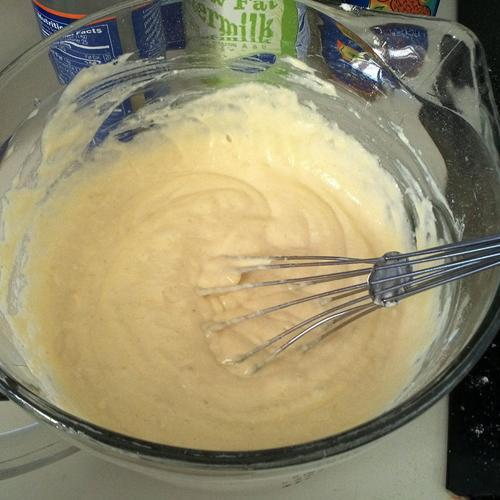

10it [00:00, 207.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

----------My normal eeg embeddings----------


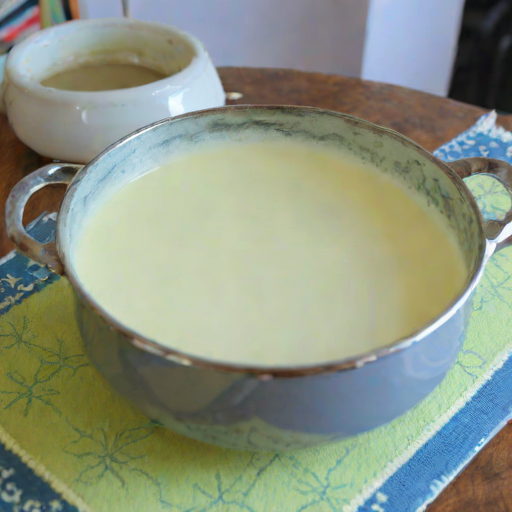

10it [00:00, 216.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

----------Old eeg embeddings----------


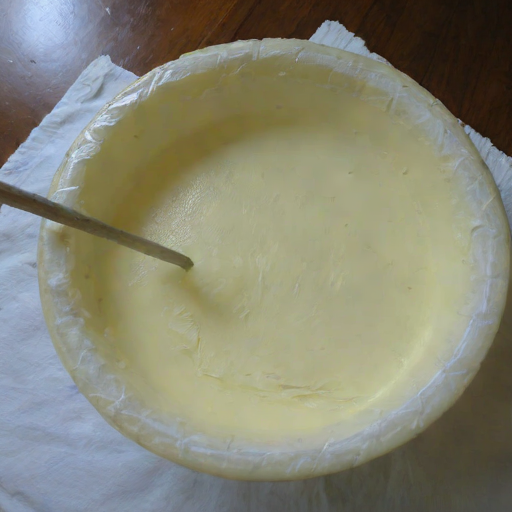

----------my diffusion weights----------
batter
----------Ground Truth----------


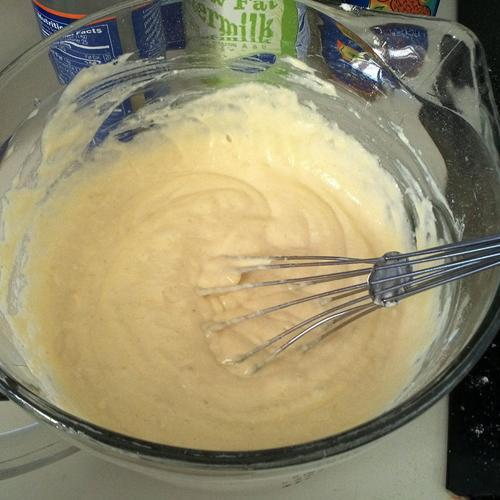

10it [00:00, 210.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

----------My normal eeg embeddings----------


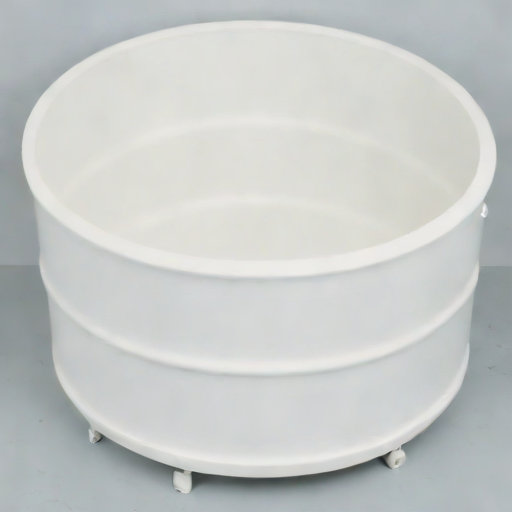

10it [00:00, 213.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

----------Old eeg embeddings----------


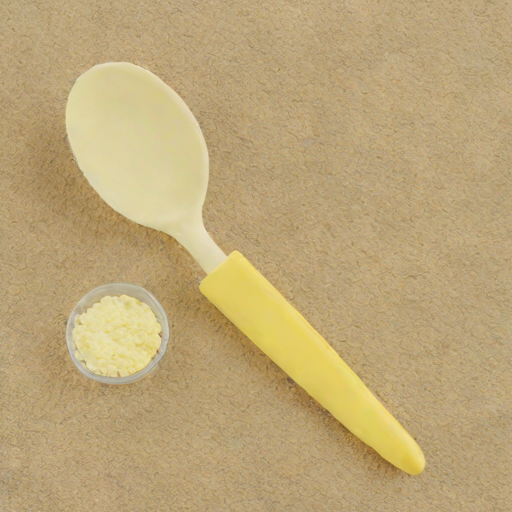

In [42]:
from IPython.display import Image, display


index = 10
for pipe_object in pipes:

    pipe = pipe_object['pipe']
    name = pipe_object['name']

    print(f'----------{name}----------')

    # for index in range(10):
    print(texts[index])
    #ground truth
    print('----------Ground Truth----------')
    display(Image(filename=images[index]))

    #h is the high level features generated by the eeg features -> diffusion u-net
    high_level_features = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)

    #Generate an image using the output of the diffusion
    image = generator.generate(high_level_features, generator=gen)  
    print('----------My normal eeg embeddings----------')
    display(image)



    # #h is the high level features generated by the eeg features -> diffusion u-net
    # high_level_features = pipe.generate(c_embeds=dreamsim_eeg[index], num_inference_steps=10, guidance_scale=2.0)

    # #Generate an image using the output of the diffusion
    # image = generator.generate(high_level_features, generator=gen)  
    # print('----------Dreamsim eeg embeddings----------')
    # display(image)


    #h is the high level features generated by the eeg features -> diffusion u-net
    high_level_features = pipe.generate(c_embeds=old_eeg[index], num_inference_steps=10, guidance_scale=2.0)

    #Generate an image using the output of the diffusion
    image = generator.generate(high_level_features, generator=gen)  
    print('----------Old eeg embeddings----------')
    display(image)

10it [00:00, 206.86it/s]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/4 [00:00<?, ?it/s]

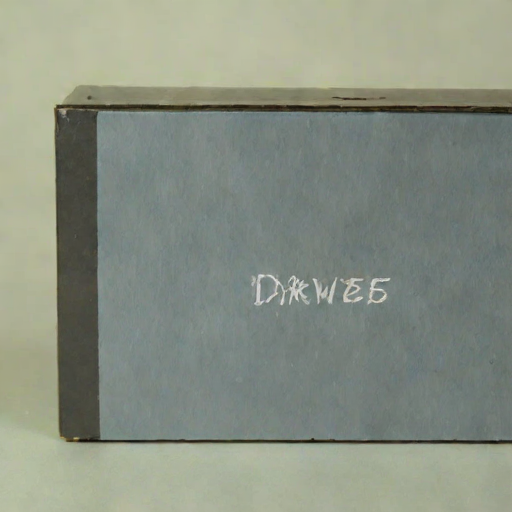

  0%|          | 0/4 [00:00<?, ?it/s]

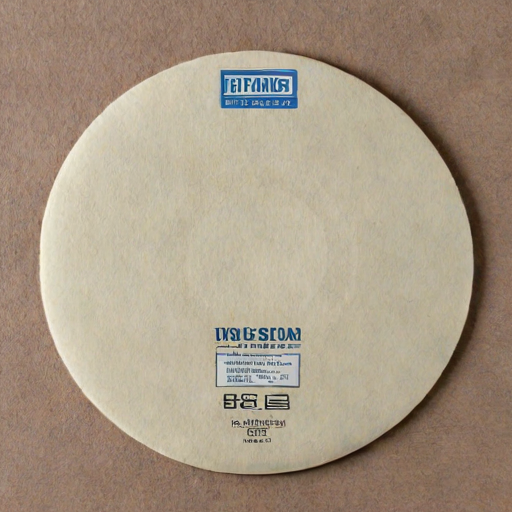

In [79]:
from IPython.display import Image, display

index = 34

#diffusion U-Net for high level features
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
pipe.diffusion_prior.load_state_dict(torch.load(f'/ibex/user/thagafhh/data/fintune_ckpts/sub-08/diffusion_prior.pt', map_location=device))

#h is the high level features generated by the eeg features -> diffusion u-net
high_level_features = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)

generator = Generator4Embeds(num_inference_steps=4, device=device)
# set a seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

#Generate an image using the eeg embeddings 
image_1 = generator.generate(eeg_embeds[index], generator=gen)  
display(image_1)

#Generate an image using the output of the diffusion
image_2 = generator.generate(high_level_features, generator=gen)  
display(image_2)


In [23]:
# with torch.no_grad():
#     x_rec = vlmodel.decode(image_latent).sample
#     image_rec = image_processor.postprocess(x_rec, output_type='pil')
#     image_rec[0].show()

/tmp/ipykernel_2440/1867616429.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pipe.diffusion_prior.load_state_dict(torch.load(f'/root/autodl-tmp/BrainAligning/fintune_

9675648


10it [00:00, 257.29it/s]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

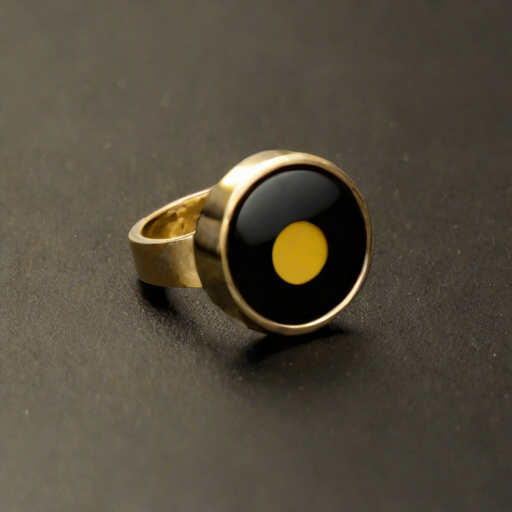

  0%|          | 0/4 [00:00<?, ?it/s]

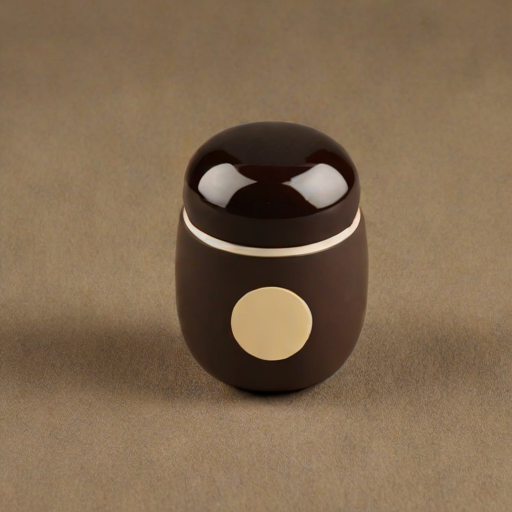

In [39]:
from IPython.display import Image, display


diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
pipe.diffusion_prior.load_state_dict(torch.load(f'/root/autodl-tmp/BrainAligning/fintune_ckpts/diffusion_prior.pt', map_location=device))
h = pipe.generate(c_embeds=eeg_embeds[index], num_inference_steps=10, guidance_scale=2.0)


generator = Generator4Embeds(num_inference_steps=4, device=device)
# set a seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

image_1 = generator.generate(eeg_embeds[index], generator=gen)  
display(image_1)

image_2 = generator.generate(h, generator=gen)  
display(image_2)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

latents torch.Size([1, 4, 64, 64])
noise torch.Size([1, 4, 64, 64])


  0%|          | 0/10 [00:00<?, ?it/s]

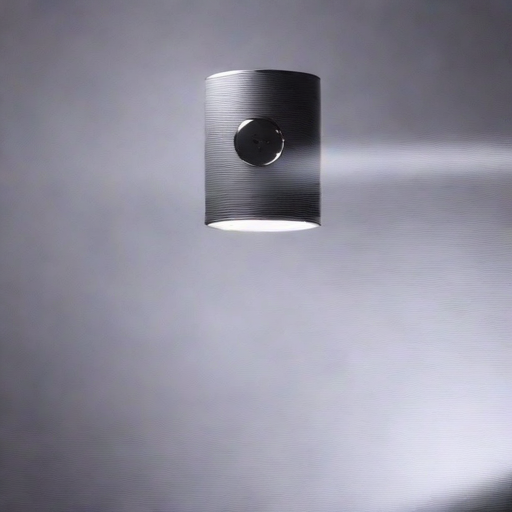

In [34]:
from IPython.display import Image, display

generator = Generator4Embeds(num_inference_steps=10, device=device, img2img_strength=0.5, low_level_image=low_level_image, low_level_latent=None)
# set a seed value
# seed_value = 30
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)
image = generator.generate(h,            
                           generator=gen)
display(image)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

latents torch.Size([1, 4, 64, 64])
noise torch.Size([1, 4, 64, 64])


  0%|          | 0/10 [00:00<?, ?it/s]

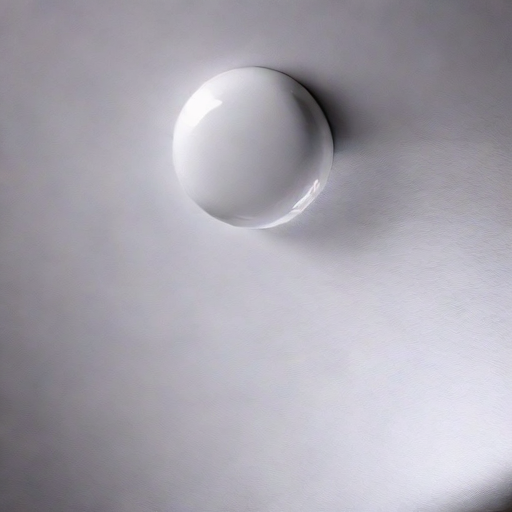

In [35]:
from IPython.display import Image, display

generator = Generator4Embeds(num_inference_steps=10, device=device, img2img_strength=0.5, low_level_image=low_level_image, low_level_latent=None)
# set a seed value
# seed_value = 30
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)
image = generator.generate(h,
                           text_prompt = "a white ceramic finish ceramic finish with a white ceramic finish.",               
                           generator=gen)
display(image)

In [36]:
# seed_value = 42
# gen = torch.Generator(device=device)
# gen.manual_seed(seed_value)
# image = generator.generate(img_feature, generator=gen)
# display(image)

In [37]:
import os
from PIL import Image
import torch
from IPython.display import display

# Assume there's a class Generator4Embeds and a clip_encoder preprocessing method
# You can modify these classes and methods based on your existing code

# Original image directory and output image directory
input_dir = '/root/autodl-tmp/BrainAligning/vae_imgs/epoch_170'
output_dir = '/root/autodl-tmp/BrainAligning/reconstructed_imgs'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Set seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

# Modify sorting function to extract the number after the first "_"
def extract_number(file_name):
    # Assume the file name format is "reconstructed_image_0_2.png"
    return int(file_name.split('_')[2])  # Extract the number after the first "_"

# Iterate through all image files in the directory and sort them by the number after the first "_"
for i, file_name in enumerate(sorted(os.listdir(input_dir), key=extract_number)):
    if i % 80 == 0:
        print(file_name)            
        if file_name.endswith(".png"):  # Only process PNG images
            img_path = os.path.join(input_dir, file_name)
            
            # Open and preprocess the image
            low_level_image = Image.open(img_path)
            # low_level_image.show()
            low_level_image = clip_encoder.preprocess(low_level_image, return_tensors="pt").pixel_values  # [1, 3, 224, 224]
            
            # Create an instance of the generator
            generator = Generator4Embeds(num_inference_steps=5, device=device, img2img_strength=0.8, low_level_image=low_level_image)
            
            # Generate the reconstructed image
            reconstructed_image = generator.generate(eeg_embeds[i // 80], generator=gen)
            
            # Save the reconstructed image to the new directory
            output_path = os.path.join(output_dir, file_name)
            reconstructed_image.save(output_path)
            
            # Optionally display the generated image
            # display(reconstructed_image)

print("All images have been successfully reconstructed and saved to:", output_dir)


FileNotFoundError: [Errno 2] No such file or directory: '/root/autodl-tmp/BrainAligning/vae_imgs/epoch_40'